# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [ ]:
#!L
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way: 
    #from gfile import download_list
    #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
#!L:bash
!unzip celeba.zip

## Prepare the data

In [1]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda:1")

In [2]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
#!L
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=1)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [6]:
#!L
dimZ = 256  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


def initialize(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)


class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()

        # TODO

        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, dimZ),
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 64 * 64),
            nn.Sigmoid()
        )
        
        self.apply(initialize)

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [7]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [8]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
from tqdm import trange, tqdm
from matplotlib import pyplot as plt


train_loss = []
val_loss = []

for epoch in trange(100):
    for (batch, attr) in train_loader:
        batch = batch.to(device).view(batch.shape[0], -1)
        reco, _ = autoencoder(batch)
        loss = criterion(reco, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().item())
    for (batch, attr) in val_loader:
        with torch.no_grad():
            batch = batch.to(device).view(batch.shape[0], -1)
            reco, _ = autoencoder(batch)
            val_loss.append(criterion(reco, batch).cpu().item())
    torch.save(autoencoder.state_dict(), f'ae_{epoch}.pt')
    print(f'train: {train_loss[-1]}, val: {val_loss[-1]}')

  1%|█▋                                                                                                                                                                        | 1/100 [02:39<4:23:22, 159.62s/it]

train: 0.006083098705857992, val: 0.00611273804679513


  2%|███▍                                                                                                                                                                      | 2/100 [05:20<4:21:52, 160.33s/it]

train: 0.0050461688078939915, val: 0.005283270962536335


  3%|█████                                                                                                                                                                     | 3/100 [08:03<4:21:24, 161.70s/it]

train: 0.009330926463007927, val: 0.008740530349314213


  3%|█████                                                                                                                                                                     | 3/100 [08:17<4:27:54, 165.72s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'val')

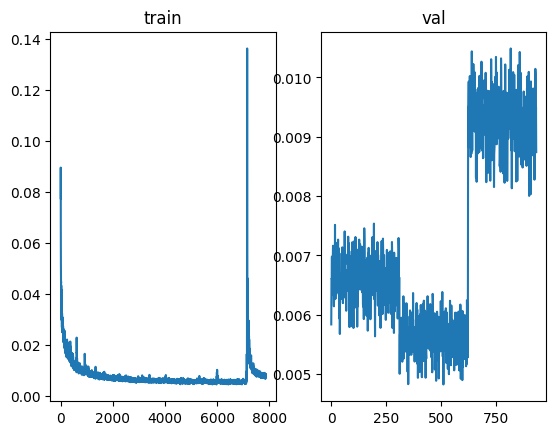

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_loss)
ax1.set_title('train')
ax2.plot(val_loss)
ax2.set_title('val')

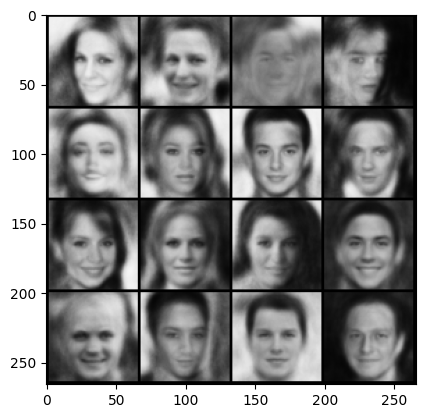

In [10]:
#!L
# Examine the reconstructions
from itertools import islice


autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('ae_1.pt'))



images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device).view(images.shape[0], -1))

reconstruction = reconstruction[:16].cpu()
reconstruction = reconstruction.view(reconstruction.shape[0], 1, 64, 64)
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

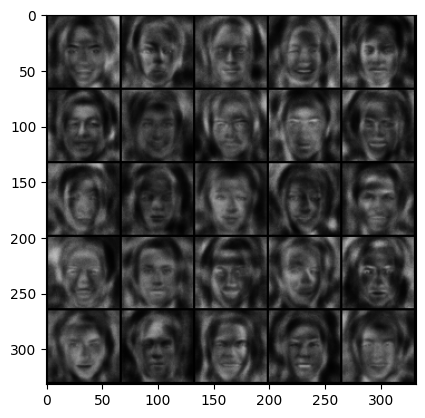

In [11]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)
reconstruction = reconstruction.view(reconstruction.shape[0], 1, 64, 64)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [16]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 512

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
from torch.nn import functional as F


class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
   
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 2 * dimZ)
        )        
        
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 64 * 64 * 2),
        )
        
        # self.reco_logsigma = torch.nn.Parameter(torch.full((1,), 0.)[0], requires_grad=True)


    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu
    
    
    def softclip(self, tensor, min):
        result_tensor = min + F.softplus(tensor - min)

        return result_tensor

    def forward(self, x):
        # TODO
        
        mu, logsigma = torch.split(self.encoder(x), dimZ, dim=-1)
        z = self.gaussian_sampler(mu, logsigma)
        reco_mu, reco_logsigma = torch.split(self.decoder(z), 64 * 64, dim=-1)
        return reco_mu.sigmoid(), self.softclip(reco_logsigma, -6), mu, logsigma
        # return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma
    
        

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [17]:
enc = VAE()
enc(torch.randn(15, 1, 64, 64).view(15, -1))

(tensor([[0.4504, 0.5690, 0.5115,  ..., 0.3834, 0.5073, 0.4605],
         [0.5415, 0.4690, 0.4743,  ..., 0.5039, 0.4627, 0.4884],
         [0.3905, 0.5544, 0.4670,  ..., 0.4106, 0.4626, 0.4213],
         ...,
         [0.5155, 0.4973, 0.5077,  ..., 0.4219, 0.4204, 0.4472],
         [0.5517, 0.4918, 0.5446,  ..., 0.5642, 0.5020, 0.3927],
         [0.4219, 0.5797, 0.4895,  ..., 0.4636, 0.4277, 0.4774]],
        grad_fn=<SigmoidBackward>),
 tensor([[-0.0474, -0.1352,  0.2250,  ...,  0.1573, -0.0038, -0.1573],
         [ 0.0549, -0.2762,  0.6609,  ...,  0.6412, -0.0360, -0.1530],
         [ 0.0388,  0.2113,  0.4663,  ...,  0.1589, -0.0572, -0.3613],
         ...,
         [ 0.0862, -0.0701,  0.3285,  ...,  0.0635, -0.0583, -0.3045],
         [-0.0381,  0.0521,  0.2212,  ...,  0.3428, -0.0566, -0.0883],
         [ 0.2795,  0.2680,  0.1525,  ...,  0.1669, -0.0749,  0.1077]],
        grad_fn=<AddBackward0>),
 tensor([[ 1.0539e-01,  4.2628e-02, -3.4555e-01,  ...,  4.2501e-03,
          -2.1085

In [58]:
#!L
import numpy as np


def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + 2 * logsigma - mu * mu - logsigma.exp() ** 2, dim=-1)


def log_likelihood(x, mu, logsigma):
    return torch.sum(-0.5 * np.log(np.pi * 2) - logsigma - 0.5 * ((mu - x) / logsigma.exp()) ** 2, dim=-1)


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    print(
        KL_divergence(mu_z, logsigma_z).mean().detach().cpu().item(), 
        log_likelihood(x, mu_gen, logsigma_gen).mean().detach().cpu().item()
    )
    return torch.mean(KL_divergence(mu_z, logsigma_z) * 50 - log_likelihood(x, mu_gen, logsigma_gen))

And train the model:

In [112]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
from tqdm import trange, tqdm
from matplotlib import pyplot as plt


train_loss = []
val_loss = []

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters())


for epoch in trange(10):
    for (batch, attr) in train_loader:
        batch = batch.to(device).view(batch.shape[0], -1)
        mu_gen, logsigma_gen, mu_z, logsigma_z = vae(batch)
        loss = loss_vae(batch, mu_gen, logsigma_gen, mu_z, logsigma_z)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 5)
        optimizer.step()
        train_loss.append(loss.detach().cpu().item())
    for (batch, attr) in val_loader:
        with torch.no_grad():
            batch = batch.to(device).view(batch.shape[0], -1)
            mu_gen, logsigma_gen, mu_z, logsigma_z = vae(batch)
            val_loss.append(loss_vae(batch, mu_gen, logsigma_gen, mu_z, logsigma_z).cpu().item())
    torch.save(autoencoder.state_dict(), f'vae_{epoch}.pt')
    print(f'train: {train_loss[-1]}, val: {val_loss[-1]}')

  0%|                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

11.465078353881836 -3946.831787109375
340.0771484375 -2753.02294921875
90.65045166015625 -2271.975341796875
27.9736328125 -1860.22265625
10.894611358642578 -1362.4532470703125
4.566159248352051 -829.7527465820312
3.3686065673828125 -457.5699462890625
2.7017860412597656 -646.150146484375
2.3666248321533203 -269.47998046875
2.5351815223693848 -437.3400573730469
2.086524724960327 -482.2880859375
2.251645565032959 -514.5841064453125
3.2709665298461914 -278.46405029296875
3.1859686374664307 -360.97479248046875
2.7795095443725586 -323.73443603515625
2.3225698471069336 -264.65093994140625
2.699204444885254 -198.6611328125
2.6474368572235107 -404.06243896484375
2.5668702125549316 -235.40675354003906
2.621682643890381 -248.15603637695312
2.5134525299072266 -407.1162109375
2.0715317726135254 -183.8340606689453
2.254530668258667 -467.2108459472656
2.346491813659668 -404.55224609375
2.7352170944213867 -417.10479736328125
2.7786734104156494 -138.7742462158203
2.5856733322143555 -423.9436950683594
1

4.186985492706299 642.0558471679688
4.403253555297852 343.70245361328125
5.479474067687988 -29.730716705322266
4.868990898132324 537.9193115234375
4.6286468505859375 362.033935546875
4.862518310546875 574.5626220703125
4.986981391906738 320.4208679199219
4.047107696533203 424.83966064453125
4.601570129394531 484.32275390625
5.011054515838623 364.12982177734375
6.530984878540039 288.3916015625
5.675598621368408 299.9845886230469
4.383391380310059 677.1818237304688
5.064491271972656 378.931884765625
4.197678565979004 489.330322265625
4.240579605102539 481.84954833984375
4.755621910095215 457.1830139160156
5.0739617347717285 737.7421264648438
4.845944404602051 556.685546875
5.959909915924072 562.6195068359375
4.950841903686523 611.1922607421875
4.932042121887207 495.36602783203125
5.031314849853516 465.20343017578125
4.886912822723389 415.417724609375
4.808187007904053 641.326416015625
6.333891868591309 575.37158203125
5.206703186035156 484.11962890625
5.420891761779785 600.0738525390625


6.4751691818237305 694.0621948242188
6.7936482429504395 746.6398315429688
8.192390441894531 614.5968017578125
7.011693954467773 896.3101806640625
7.024868488311768 502.303955078125
6.635699272155762 765.4056396484375
5.940800666809082 722.3502197265625
7.352573394775391 783.54638671875
7.079000949859619 872.692626953125
6.217756748199463 497.30194091796875
9.339225769042969 -17.444305419921875
6.971560001373291 544.7822875976562
7.594300270080566 574.53466796875
6.852560043334961 850.7440185546875
6.345829010009766 626.3409423828125
6.45791482925415 842.9328002929688
6.337221145629883 855.1038208007812
7.308798789978027 394.35516357421875
7.28012752532959 965.3134765625
7.21983003616333 651.581298828125
6.758456707000732 905.9535522460938
6.74031400680542 805.6904907226562
6.671128273010254 788.9760131835938
5.219855308532715 741.4608154296875
7.144844055175781 893.5187377929688
6.044528007507324 903.1643676757812
7.312399864196777 709.0296630859375
7.705563068389893 495.1860656738281


8.683389663696289 834.3670654296875
8.952693939208984 1025.5565185546875
9.707948684692383 1139.07421875
8.509791374206543 931.1048583984375
7.561634540557861 1030.409912109375
10.053253173828125 943.920654296875
9.242757797241211 1089.705810546875
9.78746223449707 973.0903930664062
9.016197204589844 953.68603515625
9.198415756225586 941.1793212890625
8.99074649810791 1098.039306640625
10.319502830505371 1101.6484375
9.106073379516602 1106.264404296875
8.935230255126953 1030.3907470703125
7.235332489013672 1166.003173828125
8.804529190063477 908.805908203125
10.341484069824219 855.7618408203125
10.510427474975586 1247.521484375
11.317867279052734 1074.9683837890625
12.411087989807129 937.1768798828125
9.21371841430664 1067.75244140625
9.314486503601074 953.0765380859375
8.772045135498047 1247.604248046875
8.766709327697754 983.139892578125
9.259140014648438 708.586181640625
9.36862564086914 870.7808227539062
9.868829727172852 848.0802001953125
9.457383155822754 982.523681640625
8.97365

9.43760871887207 1196.2427978515625
8.616283416748047 1418.718994140625
10.31062126159668 1116.623291015625
9.89459228515625 1245.5306396484375
8.940093994140625 1167.280517578125
11.926000595092773 1076.8438720703125
10.307113647460938 1119.5458984375
9.04429817199707 1003.8527221679688
8.359415054321289 937.61865234375
9.204357147216797 868.9722290039062
9.056046485900879 1027.48486328125
9.787942886352539 870.7008056640625
8.874515533447266 1157.1217041015625
10.17593002319336 1280.7301025390625
8.755929946899414 1090.5225830078125
7.966444969177246 912.090576171875
10.492057800292969 1027.017578125
8.96611213684082 942.420166015625
9.637399673461914 1211.8016357421875
9.943634986877441 1156.7052001953125
10.461244583129883 1032.7880859375
9.813175201416016 1031.6396484375
9.898198127746582 1235.3116455078125
10.055459976196289 1071.607177734375
8.438549995422363 1250.39208984375
9.459659576416016 1266.5130615234375
10.731273651123047 1024.22021484375
10.630245208740234 1365.0900878

9.372406005859375 962.87890625
9.45890998840332 1064.647705078125
10.526033401489258 1140.30224609375
11.511713027954102 1180.9541015625
9.184663772583008 1346.1075439453125
9.145055770874023 1274.729248046875
9.200969696044922 1184.112548828125
10.263978958129883 1121.107421875
10.442962646484375 1106.3912353515625
10.698226928710938 1008.4497680664062
10.548548698425293 1443.046142578125
10.213839530944824 1262.37548828125
10.121259689331055 842.968505859375
8.245211601257324 1262.370849609375
9.870834350585938 1273.680908203125
9.418662071228027 1101.898681640625
9.402349472045898 1112.42431640625
8.457828521728516 1056.83349609375
10.826614379882812 1044.747314453125
9.46718978881836 1268.294189453125
9.51435661315918 1196.15234375
14.318675994873047 840.3692626953125
10.630016326904297 1125.863037109375
10.933296203613281 1248.2862548828125
9.597441673278809 1122.98193359375
8.500699996948242 1144.7828369140625
9.151602745056152 905.8885498046875
10.597816467285156 1075.4545898437

11.85217571258545 1187.654541015625
10.95577621459961 1112.08203125
11.516098022460938 1274.815185546875
12.130579948425293 1128.49853515625
9.55119514465332 1148.9029541015625
9.21101188659668 1364.4642333984375
10.661273956298828 1123.7763671875
10.492134094238281 1299.26171875
11.297264099121094 1216.88427734375
12.088519096374512 1155.0284423828125
8.290450096130371 1375.95556640625
7.990137577056885 1365.79541015625
9.388154983520508 1311.28271484375
9.785208702087402 1033.9066162109375
10.268962860107422 1258.523681640625
10.338637351989746 1121.9814453125
11.584946632385254 1398.6756591796875
9.23169994354248 1030.188232421875
11.533672332763672 1235.4010009765625
9.92718505859375 1357.2706298828125
10.256623268127441 1200.664794921875
9.87578296661377 1292.453857421875
9.305387496948242 1269.5203857421875
9.854992866516113 1356.4404296875
9.065536499023438 1171.6136474609375
9.489127159118652 1280.696533203125
10.652530670166016 1105.0732421875
10.2693510055542 1125.86987304687

10.775985717773438 1482.0107421875
9.36939811706543 1171.7861328125
12.870521545410156 1036.216796875
11.380463600158691 1524.9326171875
13.092817306518555 1289.6851806640625
10.04860782623291 1465.141845703125
10.061574935913086 1362.9365234375
10.543371200561523 1306.35498046875
10.277193069458008 1345.435302734375
10.048316955566406 1405.19873046875
9.855348587036133 1422.9873046875
10.543697357177734 1436.3045654296875
12.036200523376465 1127.5128173828125
9.479732513427734 1453.221435546875
10.367623329162598 1258.3348388671875
10.715356826782227 1488.6705322265625
10.100727081298828 1275.724365234375
9.93086051940918 1421.3768310546875
10.230490684509277 1289.5875244140625
10.043376922607422 1374.1519775390625
9.723959922790527 1328.437744140625
10.155080795288086 1417.187255859375
9.356847763061523 1330.43994140625
9.829898834228516 1265.6251220703125
10.402299880981445 1284.677490234375
9.588081359863281 1021.9486083984375
11.57779598236084 1358.859619140625
11.465524673461914 

10.878142356872559 1390.3817138671875
10.713445663452148 1386.371826171875
11.007091522216797 1263.40283203125
11.127476692199707 1420.6988525390625
9.173710823059082 1337.4296875
9.668496131896973 1459.887939453125
9.69909954071045 1644.082763671875
10.555062294006348 1453.8447265625
12.270193099975586 1481.4820556640625
10.685724258422852 1188.4205322265625
10.69134521484375 1467.4627685546875
10.489362716674805 1500.27734375
10.528998374938965 1126.19677734375
10.276407241821289 1324.4222412109375
10.331441879272461 1374.168212890625
9.26522445678711 1546.4268798828125
10.839763641357422 1606.15283203125
9.392892837524414 1479.64599609375
9.39756965637207 1248.355712890625
10.255537033081055 1479.99609375
10.780658721923828 1431.1259765625
9.699457168579102 1549.369140625
11.339628219604492 1396.4881591796875
10.507452011108398 1705.373046875
10.771008491516113 1519.57666015625
9.993706703186035 1382.0721435546875
9.05947494506836 1456.71826171875
11.875578880310059 1493.24340820312

10.60946273803711 1492.0203857421875
10.229362487792969 1548.40234375
9.82492446899414 1211.123046875
9.077333450317383 1418.66552734375
12.160037994384766 1287.65185546875
11.122028350830078 1444.780029296875
11.302196502685547 1738.26611328125
11.023324012756348 1586.6494140625
10.91942024230957 1414.7625732421875
9.615735054016113 1595.8447265625
9.766570091247559 1532.88623046875
10.683880805969238 1618.8994140625
8.731273651123047 1826.911865234375
9.556541442871094 1659.5145263671875
10.745211601257324 1408.521240234375
10.544986724853516 1477.312744140625
10.209355354309082 1538.538818359375
10.292236328125 1592.07666015625
11.585381507873535 1631.155517578125
10.868438720703125 1376.999755859375
11.13044548034668 1423.3055419921875
10.868648529052734 1289.5269775390625
10.72445297241211 1453.2652587890625
11.326300621032715 999.98486328125
9.820404052734375 1383.9044189453125
9.909323692321777 1641.893798828125
10.163951873779297 1391.8692626953125
11.573143005371094 1284.90332

11.29302978515625 1484.5960693359375
10.779003143310547 1730.23583984375
10.668975830078125 1531.0999755859375
10.302532196044922 1502.783447265625
11.91075611114502 1446.3634033203125
11.365022659301758 1427.04150390625
11.678424835205078 1504.271484375
10.463188171386719 1613.37744140625
10.192110061645508 1279.533203125
10.930416107177734 1405.7855224609375
11.764755249023438 1659.7930908203125
10.778837203979492 1450.479736328125
11.720595359802246 1296.9901123046875
11.82861328125 1309.671630859375
11.308691024780273 1725.128173828125
10.857746124267578 1386.11083984375
10.44470500946045 1623.6123046875
10.397520065307617 1418.894287109375
9.981428146362305 1265.2200927734375
12.877346992492676 1452.6796875
12.166586875915527 1364.32177734375
11.766494750976562 1684.33349609375
10.609601974487305 1558.0869140625
10.25892448425293 1450.3111572265625
10.86452579498291 1531.170654296875
9.978231430053711 1645.68603515625
11.047713279724121 1396.1383056640625
10.720268249511719 1428.9

10.095015525817871 1448.2159423828125
10.543407440185547 1439.28759765625
9.40986156463623 1518.3753662109375
10.442483901977539 1533.661376953125
11.173493385314941 1419.796875
10.554914474487305 1449.8355712890625
11.157264709472656 1705.0771484375
10.137738227844238 1496.51123046875
10.803483009338379 1534.0411376953125
10.146245956420898 1665.188232421875
10.480622291564941 1680.958740234375
13.866111755371094 1504.45068359375
10.508321762084961 1426.022216796875
11.965924263000488 1426.6416015625
9.9323148727417 1642.464599609375
11.117631912231445 1388.371337890625
11.183845520019531 1515.347900390625
11.24051284790039 1372.533447265625
9.482443809509277 1708.1951904296875
11.29361343383789 1401.19873046875
10.295158386230469 1571.7705078125
12.01058578491211 1155.5252685546875
11.456457138061523 1404.329345703125
9.920974731445312 1580.8719482421875
10.773122787475586 1282.1651611328125
10.734989166259766 1622.549072265625
10.463595390319824 1501.71240234375
11.766758918762207 1

9.765257835388184 1309.0374755859375
11.270163536071777 1631.965576171875
12.328411102294922 1394.489013671875
11.31820297241211 1747.782958984375
11.348089218139648 1473.847900390625
10.177998542785645 1467.5732421875
10.454156875610352 1546.184814453125
10.316043853759766 1340.1435546875
10.068962097167969 1543.7840576171875
10.119715690612793 1593.8505859375
11.279247283935547 1333.486572265625
10.813899993896484 1427.9088134765625
11.245841979980469 1394.52783203125
10.267364501953125 1531.1514892578125
10.236668586730957 1801.75341796875
10.918954849243164 1620.82958984375
10.400808334350586 1574.615966796875
10.308199882507324 1659.12548828125
11.116094589233398 1525.6168212890625
11.907923698425293 1367.458251953125
10.54971694946289 1424.14892578125
9.949987411499023 1540.037353515625
11.092660903930664 1565.08642578125
10.6854248046875 1537.177001953125
11.421533584594727 1356.517578125
9.749488830566406 1469.7984619140625
9.871562957763672 1373.8687744140625
10.10877037048339

 10%|█████████████████▎                                                                                                                                                           | 1/10 [02:27<22:06, 147.42s/it]

10.113006591796875 1514.0362548828125
10.145658493041992 1692.7381591796875
train: -828.345458984375, val: -1185.4552001953125
11.805785179138184 1566.8175048828125
10.53599739074707 1523.247314453125
11.933955192565918 1389.1180419921875
10.497598648071289 1547.7744140625
11.448307037353516 1403.0091552734375
11.481721878051758 1516.281494140625
10.466094970703125 1522.6641845703125
11.117573738098145 1660.64306640625
11.042801856994629 1408.174560546875
11.542132377624512 1398.6552734375
11.490639686584473 1587.9384765625
11.973319053649902 1548.0203857421875
10.988811492919922 1338.254638671875
10.82861328125 1495.28955078125
10.92166519165039 1505.9285888671875
10.834356307983398 1312.328369140625
10.625800132751465 1625.2333984375
10.586797714233398 1497.5650634765625
10.66172981262207 1372.779296875
10.80313491821289 1676.66162109375
10.123514175415039 1574.971923828125
11.476020812988281 1463.9698486328125
10.40267276763916 1298.281494140625
11.406103134155273 1592.69140625
12.3

10.176021575927734 1360.741943359375
10.292266845703125 1311.6719970703125
11.174278259277344 1369.490966796875
10.934688568115234 1533.413818359375
11.678285598754883 1538.330810546875
10.735610008239746 1711.909423828125
10.758833885192871 1539.0557861328125
10.206459999084473 1535.9696044921875
10.556535720825195 1469.169921875
11.895807266235352 1586.0888671875
13.307281494140625 1471.86962890625
11.260069847106934 1525.8905029296875
12.357404708862305 1539.394287109375
11.076000213623047 1176.8240966796875
11.696908950805664 1704.6455078125
12.027423858642578 1562.916015625
10.767528533935547 1587.7894287109375
10.740583419799805 1463.214111328125
10.563196182250977 1526.74560546875
11.299285888671875 1260.2288818359375
13.069170951843262 1473.5362548828125
12.677227020263672 1516.06884765625
11.724440574645996 1253.528564453125
12.143272399902344 1203.242431640625
12.828279495239258 1531.9033203125
11.294086456298828 1484.47802734375
9.713961601257324 1470.7659912109375
10.279137

12.076963424682617 1204.6024169921875
12.6422119140625 1349.22412109375
12.674476623535156 1499.496337890625
11.204150199890137 1527.864990234375
11.80681037902832 1526.495361328125
11.006163597106934 1622.385986328125
10.593570709228516 1353.261474609375
11.329645156860352 1480.381103515625
11.160388946533203 1512.851806640625
12.20492935180664 1553.947998046875
11.29150676727295 1592.4912109375
12.289754867553711 1591.5548095703125
12.838102340698242 1609.566162109375
10.232499122619629 1573.548828125
11.978235244750977 1504.825927734375
10.787080764770508 1501.030029296875
10.2005033493042 1705.345947265625
12.267545700073242 1607.306640625
10.6674222946167 1730.3306884765625
10.387907028198242 1456.0126953125
9.550678253173828 1517.823486328125
11.174099922180176 1566.870361328125
10.570096969604492 1381.517822265625
11.173630714416504 1610.3013916015625
11.074621200561523 1589.506103515625
11.553179740905762 1533.3192138671875
11.299236297607422 1576.3612060546875
12.0369796752929

10.843358039855957 1692.0069580078125
11.247093200683594 1367.489013671875
12.237689971923828 1609.282958984375
10.938182830810547 1558.3671875
12.024253845214844 1538.7366943359375
11.884012222290039 1740.3758544921875
13.08285140991211 1555.577392578125
12.193355560302734 1506.84716796875
10.84149169921875 1571.219482421875
11.717571258544922 1488.880615234375
11.650829315185547 1638.1082763671875
11.145975112915039 1762.469970703125
11.30378246307373 1658.7454833984375
13.187018394470215 1502.78076171875
12.321089744567871 1612.840087890625
11.394935607910156 1575.138916015625
11.427383422851562 1522.3426513671875
11.679361343383789 1345.1982421875
10.788375854492188 1579.13818359375
11.844686508178711 1658.34375
11.830297470092773 1250.5501708984375
10.412532806396484 1761.638671875
10.176153182983398 1344.98779296875
12.345608711242676 1396.171142578125
11.232218742370605 1653.178466796875
12.369638442993164 1519.77783203125
12.045148849487305 1544.223388671875
10.293689727783203 

10.763343811035156 1391.491455078125
12.8703031539917 1624.2322998046875
12.024826049804688 1625.684814453125
11.229166030883789 1497.9879150390625
10.335205078125 1806.6971435546875
11.144723892211914 1846.678466796875
11.434350967407227 1764.53173828125
12.4967679977417 1483.45556640625
12.874204635620117 1667.1817626953125
11.657886505126953 1653.9971923828125
12.200037002563477 1653.8316650390625
11.157489776611328 1489.1572265625
11.773680686950684 1635.46142578125
11.167749404907227 1720.303955078125
11.339284896850586 1696.866943359375
11.391356468200684 1584.0174560546875
11.970855712890625 1653.8388671875
12.856346130371094 1668.17919921875
11.812713623046875 1708.238037109375
12.131826400756836 1688.666015625
11.898168563842773 1385.4119873046875
11.52914810180664 1541.391357421875
11.976226806640625 1643.13134765625
12.733695030212402 1629.9483642578125
12.24847412109375 1553.6351318359375
10.843452453613281 1475.810791015625
10.330707550048828 1718.80908203125
12.3924865722

12.853540420532227 1376.3287353515625
12.19607162475586 1729.4525146484375
11.538349151611328 1612.040771484375
12.116844177246094 1351.25732421875
10.302650451660156 1642.635498046875
11.126344680786133 1523.522216796875
10.382909774780273 1527.72705078125
10.119518280029297 1657.4464111328125
13.219560623168945 1621.7437744140625
11.572274208068848 1428.48974609375
10.753317832946777 1607.7255859375
10.55213737487793 1629.026611328125
11.340592384338379 1581.972900390625
10.415898323059082 1617.810546875
11.612751007080078 1650.05126953125
12.928926467895508 1321.2310791015625
13.532940864562988 1438.0155029296875
11.418651580810547 1531.13427734375
11.975824356079102 1651.63037109375
12.791768074035645 1552.252685546875
10.189729690551758 1583.8331298828125
11.363192558288574 1582.096435546875
12.78983211517334 1556.993408203125
10.96834659576416 1706.3985595703125
10.204357147216797 1644.0887451171875
13.047816276550293 1712.43505859375
11.867788314819336 1762.6165771484375
12.9288

11.29867172241211 1774.27880859375
12.995462417602539 1714.617919921875
11.40677547454834 1615.41455078125
11.07746410369873 1851.642333984375
11.314170837402344 1735.0390625
10.95155143737793 1611.0771484375
11.88778305053711 1677.696533203125
12.564741134643555 1675.5946044921875
12.616315841674805 1543.0263671875
12.687143325805664 1781.8675537109375
11.686602592468262 1549.4937744140625
13.08090877532959 1528.340087890625
12.290884017944336 1654.91845703125
12.54932975769043 1301.7745361328125
12.782581329345703 1631.782958984375
12.177770614624023 1776.791015625
11.735942840576172 1545.604736328125
12.04685115814209 1519.857666015625
11.96934986114502 1620.43603515625
11.442144393920898 1679.2188720703125
12.610757827758789 1687.1259765625
12.29233169555664 1457.191650390625
11.075160026550293 1708.40673828125
10.92318344116211 1636.975830078125
12.79007339477539 1421.69091796875
12.566076278686523 1412.274169921875
12.201868057250977 1818.491943359375
11.583654403686523 1634.6552

11.328405380249023 1852.0933837890625
11.396929740905762 1594.107177734375
11.303239822387695 1688.445068359375
11.500341415405273 1479.4644775390625
13.930021286010742 1674.96875
11.372906684875488 1768.0054931640625
13.013710021972656 1804.9083251953125
14.325105667114258 1624.302734375
11.809569358825684 1554.739013671875
11.359195709228516 1548.72216796875
10.51777458190918 1834.1712646484375
10.871219635009766 1543.9375
11.364400863647461 1762.7545166015625
11.712100982666016 1694.011474609375
11.20358943939209 1763.666748046875
10.60295295715332 1695.643310546875
11.027202606201172 1741.05810546875
11.107630729675293 1584.479248046875
12.467842102050781 1746.752685546875
12.716287612915039 1709.8671875
12.039321899414062 1836.7452392578125
11.95068359375 1565.924560546875
11.2232666015625 1815.8963623046875
11.34708023071289 1689.73681640625
11.771337509155273 1592.5927734375
12.356709480285645 1807.765625
11.73891830444336 1689.4083251953125
11.95785140991211 1604.01416015625
11

11.122268676757812 1666.4888916015625
11.729806900024414 1709.75341796875
11.79797649383545 1773.77294921875
12.886838912963867 1568.91650390625
12.896787643432617 1865.0931396484375
11.930061340332031 1703.553955078125
10.7539701461792 1888.9639892578125
12.205490112304688 1767.61669921875
12.168548583984375 1759.281982421875
11.49884033203125 1736.34130859375
12.911173820495605 1738.564697265625
11.484403610229492 1695.211669921875
11.7741060256958 1654.5799560546875
12.996023178100586 1860.8944091796875
10.228107452392578 1746.6275634765625
12.319055557250977 1722.663330078125
12.166637420654297 1659.9951171875
11.88010025024414 1461.360595703125
12.046883583068848 1731.1617431640625
11.827780723571777 1825.188720703125
11.015420913696289 1875.083984375
11.788555145263672 1709.856689453125
11.387102127075195 1725.7406005859375
11.487876892089844 1696.112548828125
11.44355297088623 1634.9056396484375
12.025984764099121 1502.81298828125
12.942852020263672 1529.961181640625
12.02496337

11.196481704711914 1665.396240234375
12.821630477905273 1639.918701171875
11.414090156555176 1788.4635009765625
11.27641487121582 1724.83642578125
11.363534927368164 1730.21435546875
11.467015266418457 1633.221923828125
11.927480697631836 1699.29150390625
11.378397941589355 1719.473876953125
12.155712127685547 1647.8682861328125
11.349550247192383 1625.19873046875
12.673294067382812 1631.578369140625
12.447931289672852 1673.260986328125
11.308250427246094 1754.149658203125
11.095304489135742 1773.7845458984375
10.936527252197266 1597.7647705078125
11.081859588623047 1916.326416015625
12.409845352172852 1639.448486328125
11.828093528747559 1674.416259765625
12.423818588256836 1631.02978515625
10.757837295532227 1855.2900390625
11.893712043762207 1846.65869140625
11.019479751586914 1889.6466064453125
11.799381256103516 1643.189697265625
11.460432052612305 1857.7177734375
11.65343189239502 1442.19580078125
12.648609161376953 1786.9544677734375
14.102705001831055 1745.904296875
12.60020256

13.415422439575195 1863.879638671875
10.843889236450195 1770.2515869140625
12.274982452392578 1904.8240966796875
12.1480073928833 1594.17578125
11.264028549194336 1529.32177734375
12.88762378692627 1965.1046142578125
12.307113647460938 1742.802978515625
12.796089172363281 1736.394287109375
12.009201049804688 1820.445556640625
11.172496795654297 1951.71435546875
11.656753540039062 1846.539306640625
10.818851470947266 1819.7442626953125
12.586511611938477 1667.99462890625
12.666820526123047 1836.615966796875
12.754039764404297 1906.5699462890625
12.723653793334961 1823.1298828125
13.007135391235352 1838.62158203125
12.825632095336914 1892.186767578125
11.241600036621094 1816.4150390625
12.823282241821289 1897.747802734375
12.93465805053711 1694.2425537109375
12.42037582397461 1899.8785400390625
11.857858657836914 1925.7742919921875
11.192895889282227 2053.447265625
11.087884902954102 1721.2274169921875
10.852327346801758 1980.6456298828125
12.067626953125 1653.6630859375
12.6108589172363

11.237406730651855 1788.3394775390625
11.45182991027832 1912.07763671875
11.090923309326172 1805.26904296875
11.58837890625 1871.0091552734375
12.934089660644531 1676.8565673828125
12.340145111083984 2037.51025390625
11.760013580322266 1835.94482421875
11.587705612182617 1828.30908203125
12.988643646240234 1781.3800048828125
12.226597785949707 1917.8270263671875
12.661043167114258 1656.022705078125
12.416560173034668 1886.1929931640625
12.29499626159668 1727.614990234375
11.110586166381836 1908.828857421875
13.294017791748047 1775.4000244140625
12.26077651977539 1929.54150390625
11.200689315795898 2057.8349609375
13.341554641723633 1884.1162109375
12.805563926696777 1778.1402587890625
11.474016189575195 1585.005859375
11.894912719726562 1690.4564208984375
13.347018241882324 1777.1024169921875
12.971824645996094 2000.3602294921875
11.48065185546875 2033.35888671875
11.733330726623535 1645.68359375
12.11499309539795 1640.66845703125
12.077400207519531 1601.049072265625
14.264366149902344

12.222288131713867 1834.49609375
12.434101104736328 1725.36962890625
12.275747299194336 1700.2001953125
13.569901466369629 1608.5322265625
11.2555513381958 1896.958251953125
11.200815200805664 1801.281005859375
13.247413635253906 1739.6309814453125
12.676935195922852 1927.611328125
11.220548629760742 1984.41162109375
12.641716003417969 1709.05322265625
12.51429557800293 1818.41455078125
13.299249649047852 1829.8028564453125
12.998276710510254 1910.8555908203125
12.300158500671387 1778.388427734375
12.299629211425781 1654.91552734375
12.575643539428711 1758.912353515625
11.816221237182617 1827.146728515625
11.374988555908203 1803.435546875
11.813774108886719 1828.7880859375
13.904241561889648 1685.029296875
11.79802131652832 1743.9722900390625
12.85352897644043 2022.404052734375
12.529293060302734 1752.9837646484375
13.314882278442383 1814.45556640625
13.041192054748535 1834.37646484375
11.471227645874023 1602.59619140625
12.565378189086914 1945.101318359375
13.975668907165527 1605.4597

 20%|██████████████████████████████████▌                                                                                                                                          | 2/10 [04:51<19:24, 145.58s/it]

11.637876510620117 2013.4097900390625
train: -1603.7596435546875, val: -1431.515869140625
11.414170265197754 1796.54638671875
10.884377479553223 1885.751708984375
11.478302001953125 1787.0
11.750120162963867 1944.491455078125
11.881457328796387 1889.0919189453125
11.61945915222168 1907.226806640625
12.463193893432617 1847.955078125
12.61363410949707 1870.125
12.373805046081543 1589.1107177734375
11.091259002685547 1846.239990234375
11.524019241333008 1845.8387451171875
11.2438325881958 1812.938232421875
11.664037704467773 1796.1064453125
11.938047409057617 1731.190673828125
12.814346313476562 1727.8406982421875
12.603174209594727 2013.8453369140625
12.742170333862305 1691.51513671875
11.976713180541992 1702.21142578125
12.317244529724121 1754.435302734375
12.324601173400879 1891.137451171875
13.053963661193848 1493.78369140625
13.07724380493164 1614.8636474609375
11.058755874633789 1702.765869140625
12.307188034057617 1722.950927734375
12.013827323913574 1669.8782958984375
12.296810150

12.312294006347656 1840.289306640625
12.063061714172363 1635.891357421875
12.717302322387695 1814.590087890625
13.878396034240723 1852.24755859375
11.480627059936523 1884.39501953125
12.123067855834961 1711.681884765625
12.426763534545898 1691.126708984375
12.636528015136719 1755.505126953125
13.549506187438965 1836.1710205078125
11.597383499145508 1723.453369140625
11.584365844726562 2035.82958984375
11.949882507324219 1849.7432861328125
12.378480911254883 1738.882080078125
12.190226554870605 1770.3524169921875
13.289590835571289 1907.6910400390625
12.106398582458496 1963.010986328125
13.946975708007812 1603.887939453125
13.104063034057617 1780.380859375
12.321523666381836 1852.272705078125
12.357574462890625 1686.0875244140625
12.5416898727417 2151.2587890625
11.113653182983398 1940.417724609375
13.188899993896484 1681.384521484375
11.480462074279785 1945.168212890625
11.589107513427734 1784.060546875
11.961153030395508 1943.326904296875
13.230728149414062 1819.6650390625
10.70919895

12.02985668182373 2003.3310546875
11.107646942138672 2145.659912109375
12.29852294921875 1996.1646728515625
13.268821716308594 1732.53076171875
12.056407928466797 1919.677001953125
12.652643203735352 1838.119873046875
11.260795593261719 2024.4881591796875
11.75494384765625 2210.87158203125
12.784672737121582 1892.23876953125
11.999747276306152 1631.275634765625
12.450887680053711 2040.392578125
12.381410598754883 1912.67822265625
12.026838302612305 1860.3271484375
14.005254745483398 1735.419921875
12.811129570007324 2054.26416015625
12.352102279663086 1779.095947265625
12.373987197875977 1701.0263671875
13.842278480529785 2148.0107421875
12.626252174377441 1994.839599609375
12.547344207763672 1955.1544189453125
12.223318099975586 1851.154541015625
13.369340896606445 1623.7374267578125
13.989255905151367 1920.7421875
12.48443603515625 1843.8896484375
12.912263870239258 1921.467529296875
11.425094604492188 1855.470703125
11.683887481689453 1910.341796875
13.010940551757812 1621.481933593

14.602802276611328 2019.2333984375
12.896533966064453 1858.0384521484375
11.957796096801758 1917.501953125
12.3859224319458 2004.711669921875
12.542825698852539 1857.354248046875
12.87526798248291 2071.7001953125
13.106703758239746 1838.00146484375
12.824687957763672 1765.23583984375
11.476848602294922 2028.32666015625
13.071916580200195 2050.96142578125
11.626948356628418 1846.48681640625
11.527311325073242 1843.0003662109375
13.549287796020508 1880.828369140625
13.561902046203613 1963.01318359375
13.420500755310059 1978.7041015625
12.159263610839844 2061.69580078125
13.788973808288574 1632.13623046875
11.643348693847656 1902.8145751953125
11.335208892822266 1810.109130859375
13.233565330505371 1987.80419921875
14.57912540435791 2002.3409423828125
12.729110717773438 1926.056884765625
11.738388061523438 1932.933349609375
12.66264533996582 1858.098388671875
12.191020965576172 1879.764892578125
13.255887031555176 1723.08935546875
12.164020538330078 1980.96875
13.005168914794922 2007.8659

13.163068771362305 1850.8460693359375
14.141918182373047 2002.2674560546875
12.573147773742676 2049.5244140625
12.79737377166748 2019.571533203125
12.526778221130371 2100.940673828125
11.724367141723633 2049.08251953125
13.449524879455566 1933.114501953125
11.742362976074219 1886.626708984375
13.3712158203125 2124.9619140625
14.4121732711792 1704.6602783203125
13.970544815063477 1971.37109375
13.54358196258545 1841.66943359375
12.31976318359375 1919.2138671875
12.986394882202148 1807.4827880859375
12.415702819824219 1919.773681640625
11.663684844970703 1840.68310546875
13.536032676696777 1850.6064453125
12.381512641906738 1972.334716796875
12.263174057006836 1852.38427734375
12.499849319458008 1847.9801025390625
11.27423095703125 1903.2113037109375
12.7267484664917 2030.4979248046875
13.634197235107422 1981.216796875
11.536949157714844 2107.26318359375
13.063492774963379 1909.26220703125
13.7586088180542 1946.4825439453125
12.112672805786133 2073.308349609375
13.120523452758789 1854.89

12.56757640838623 1884.490966796875
11.976944923400879 2087.76416015625
12.840880393981934 1721.206298828125
12.39355754852295 1996.6397705078125
13.434921264648438 1960.994384765625
12.65957260131836 1856.4578857421875
12.67542839050293 2066.33203125
12.624314308166504 1772.066650390625
13.3021821975708 1726.33203125
11.737421035766602 1939.885498046875
12.813165664672852 1925.99658203125
13.203741073608398 2034.5576171875
12.729814529418945 1885.93115234375
12.861289024353027 2009.306396484375
14.44593334197998 1788.633544921875
12.400508880615234 2005.5404052734375
12.569408416748047 2001.053955078125
13.761653900146484 1903.4266357421875
14.28766918182373 1737.291748046875
13.691438674926758 2004.183349609375
12.491934776306152 2047.050048828125
13.350106239318848 1778.876953125
11.984169006347656 2165.16943359375
13.685016632080078 1821.1392822265625
13.811283111572266 1847.4365234375
14.397114753723145 1950.94970703125
12.151216506958008 1959.28515625
12.680335998535156 1722.3283

12.931910514831543 2050.50244140625
13.866209030151367 1900.673828125
14.348164558410645 1830.9908447265625
13.24425220489502 2111.713134765625
13.84119987487793 1862.0247802734375
13.422327041625977 1811.489990234375
12.056035995483398 1965.1063232421875
12.91854476928711 1933.734375
12.176263809204102 1971.706298828125
13.905996322631836 2008.4345703125
13.636946678161621 1918.75
14.096397399902344 1879.3763427734375
11.497803688049316 2071.47802734375
12.390480041503906 1935.07275390625
13.772390365600586 1968.510009765625
13.24071216583252 1937.9757080078125
13.089361190795898 2068.19140625
13.201536178588867 1829.6903076171875
15.506590843200684 1939.5654296875
13.030489921569824 1893.0638427734375
12.980003356933594 2041.5225830078125
12.580489158630371 1951.1046142578125
13.48730754852295 1954.8470458984375
12.072088241577148 1986.2403564453125
12.535074234008789 2031.0986328125
15.490019798278809 1990.6376953125
13.101465225219727 1934.96142578125
12.854959487915039 1947.061889

13.354601860046387 2023.4114990234375
14.832433700561523 2081.78125
13.34763240814209 2084.989501953125
14.278715133666992 1905.43017578125
13.905569076538086 2174.966796875
12.592695236206055 2140.666259765625
12.51194953918457 2026.79150390625
14.200634002685547 1903.172119140625
14.636762619018555 1959.8525390625
13.429473876953125 1885.437744140625
14.339030265808105 1922.78759765625
12.895758628845215 2215.01416015625
14.396103858947754 2030.065673828125
12.625738143920898 1937.8193359375
13.291677474975586 2001.19189453125
14.063130378723145 2014.2139892578125
12.757532119750977 2070.916748046875
11.914855003356934 2114.21337890625
12.247928619384766 2063.244384765625
12.821849822998047 2111.16357421875
12.80170726776123 1836.1025390625
13.62936782836914 2252.8046875
14.305509567260742 2025.4066162109375
14.468461990356445 2037.352783203125
14.067628860473633 1898.565185546875
14.68046760559082 1958.4708251953125
13.745105743408203 1628.334228515625
13.610967636108398 2211.822265

13.620287895202637 2242.47705078125
14.398780822753906 1969.323974609375
13.733201026916504 1984.8173828125
14.19247817993164 1941.786376953125
13.79956340789795 2179.275390625
12.568206787109375 2134.732666015625
12.164168357849121 2234.99951171875
12.719586372375488 1975.1375732421875
12.728864669799805 1970.13525390625
13.550943374633789 2110.687744140625
16.766416549682617 1948.549560546875
14.416053771972656 1971.98193359375
12.92216682434082 2088.443359375
14.25990104675293 2146.378662109375
14.524688720703125 2194.914794921875
13.850639343261719 2271.09033203125
13.91607666015625 2034.64208984375
13.829107284545898 2044.6337890625
12.941400527954102 2132.67919921875
13.407330513000488 2134.8505859375
12.939888954162598 2022.6932373046875
13.257161140441895 2254.662353515625
14.094133377075195 2281.3623046875
14.195727348327637 2156.137451171875
13.19117259979248 2094.2763671875
12.634025573730469 2130.01318359375
13.424042701721191 2046.0150146484375
12.442621231079102 2223.2709

13.217494010925293 2000.299072265625
13.434062957763672 2265.32861328125
13.309442520141602 2184.3349609375
13.094236373901367 2354.80810546875
13.748392105102539 2230.039306640625
12.65985107421875 2354.90234375
13.23875904083252 2284.500244140625
13.411630630493164 2275.40673828125
12.598017692565918 2168.8701171875
13.640475273132324 2050.63720703125
13.5994873046875 2097.66259765625
12.60982608795166 2249.11962890625
14.020626068115234 1994.2476806640625
12.570442199707031 1968.457763671875
12.796063423156738 2118.11474609375
14.34102725982666 2020.20166015625
12.475866317749023 2106.828125
12.215295791625977 2300.49560546875
13.397478103637695 2171.04296875
12.993562698364258 2366.03369140625
14.192302703857422 2216.750244140625
13.743768692016602 1744.8017578125
14.509659767150879 2124.564453125
13.851664543151855 2130.52587890625
13.56307601928711 2108.02734375
13.503110885620117 2194.31005859375
12.997710227966309 2177.2685546875
13.944323539733887 1956.4058837890625
12.4623336

13.980453491210938 1987.2117919921875
13.393355369567871 2171.22900390625
13.835958480834961 2181.88037109375
14.066615104675293 2214.74853515625
14.004242897033691 2137.000732421875
13.511271476745605 2310.54052734375
12.479541778564453 2195.128173828125
12.389318466186523 2334.51416015625
13.317258834838867 2139.186767578125
12.765236854553223 2206.4560546875
14.101591110229492 2164.945068359375
13.642921447753906 2284.95654296875
14.282386779785156 2105.67822265625
14.555002212524414 2020.6275634765625
13.125019073486328 2113.416748046875
13.300780296325684 2170.2060546875
13.221097946166992 2116.9208984375
13.53133487701416 2155.9521484375
13.036035537719727 2196.21337890625
14.996330261230469 2056.106689453125
13.211175918579102 2099.948974609375
13.521184921264648 1985.9686279296875
12.807193756103516 2200.2529296875
13.060312271118164 2090.445556640625
14.44921875 2145.246337890625
13.688055992126465 2119.37548828125
14.08678913116455 2254.448486328125
13.722274780273438 2191.42

13.923223495483398 1993.80810546875
12.703413009643555 2142.583740234375
12.913236618041992 2285.838134765625
12.54124927520752 2385.222900390625
12.672091484069824 2305.95849609375
14.347604751586914 2111.54296875
14.022916793823242 2303.970703125
13.681415557861328 2093.58642578125
13.043601989746094 2262.29541015625
13.434484481811523 2101.12841796875
14.033949851989746 2197.3798828125
14.116275787353516 1918.726318359375
13.522449493408203 2042.248779296875
13.204505920410156 2267.6962890625
13.352496147155762 2234.11962890625
14.57631778717041 2231.111572265625
14.14364242553711 2295.66259765625
14.446012496948242 2110.125
14.121726989746094 2131.1416015625
14.672128677368164 1976.10302734375
12.588894844055176 2257.001953125
14.099154472351074 2118.12890625
14.186935424804688 2164.492431640625
14.814748764038086 2086.3251953125
14.684391021728516 2062.12451171875
13.704317092895508 2095.65625
13.600147247314453 2001.7900390625
13.29623794555664 2274.559814453125
13.69959068298339

14.619085311889648 2031.2491455078125
14.37076187133789 2244.83203125
13.88774299621582 2062.08154296875
13.984965324401855 2257.020263671875
13.898011207580566 2133.837158203125
13.853887557983398 2179.225830078125
13.188125610351562 2168.8720703125
13.239462852478027 2198.4814453125
14.417842864990234 2030.2198486328125
13.92103385925293 2115.12841796875
14.336954116821289 2140.90771484375
13.61532211303711 2055.5234375
13.624706268310547 2447.40771484375
14.056982040405273 2246.7900390625
13.792566299438477 2248.080078125
13.49280071258545 2272.319580078125
14.382678031921387 2064.020263671875
15.797513961791992 1855.697998046875
13.696978569030762 1874.0853271484375
13.241057395935059 2137.523681640625
13.756471633911133 2149.4091796875
13.793856620788574 2182.278076171875
14.15090560913086 1889.669921875
12.880949020385742 1933.2725830078125
13.866181373596191 2023.7335205078125
13.582718849182129 2239.91552734375
14.62168025970459 2129.20703125
14.351582527160645 2138.21606445312

 30%|███████████████████████████████████████████████████▉                                                                                                                         | 3/10 [07:18<17:03, 146.21s/it]

13.94819450378418 2056.146240234375
13.416996002197266 2198.960693359375
train: -1502.2957763671875, val: -1528.111083984375
14.426998138427734 2225.99658203125
14.704882621765137 2164.13916015625
14.11733627319336 2142.07958984375
12.844058990478516 2285.04736328125
14.177826881408691 1951.9052734375
12.938438415527344 2439.404052734375
13.7240571975708 2210.879638671875
12.89211368560791 2343.3525390625
12.97929573059082 2306.803955078125
14.019631385803223 2271.383544921875
12.855058670043945 2381.45849609375
12.717977523803711 2259.20703125
13.19035530090332 2189.57373046875
13.830926895141602 2200.44677734375
12.564788818359375 2298.94873046875
14.196817398071289 2028.9027099609375
13.678207397460938 2158.381591796875
13.074539184570312 2275.089599609375
13.582708358764648 2100.29443359375
13.439175605773926 2266.857666015625
13.230660438537598 2004.6383056640625
13.661195755004883 2173.7802734375
13.55618953704834 2221.648681640625
14.030126571655273 2128.39404296875
13.382303237

13.877541542053223 2219.764892578125
13.54347038269043 2366.65185546875
14.131765365600586 2245.10009765625
14.479419708251953 2085.057373046875
14.353677749633789 2330.658935546875
14.071470260620117 2328.853271484375
13.368501663208008 2273.545166015625
12.857036590576172 2176.224853515625
13.136274337768555 2334.4873046875
14.157233238220215 2436.200439453125
14.156377792358398 2210.45263671875
13.813218116760254 2301.6787109375
13.83481502532959 2391.07421875
13.153264999389648 2335.870849609375
14.757765769958496 2164.2998046875
14.821698188781738 2057.719482421875
12.950151443481445 2350.218017578125
13.50319766998291 2153.333740234375
12.996774673461914 2180.029052734375
14.440077781677246 2137.53076171875
12.804107666015625 2326.2646484375
15.05558967590332 2212.7998046875
14.859869003295898 2070.279296875
14.673727035522461 2026.92431640625
13.403996467590332 2375.81103515625
13.786941528320312 2158.122802734375
13.33213996887207 2350.084716796875
13.338369369506836 2335.68286

13.874775886535645 2302.673828125
12.508916854858398 2492.52099609375
12.730413436889648 2070.966796875
13.968807220458984 2181.778076171875
13.770242691040039 2504.466796875
14.0350923538208 2194.766357421875
13.037879943847656 2183.290771484375
13.635567665100098 2044.01708984375
12.96408462524414 2253.509765625
13.242658615112305 2282.67529296875
13.113677024841309 2176.192626953125
15.705658912658691 2033.394775390625
15.91788101196289 2176.241943359375
14.56747055053711 2305.919921875
14.791357040405273 2267.591064453125
14.166678428649902 2199.25830078125
14.716331481933594 2159.69970703125
12.866458892822266 2378.37158203125
13.530302047729492 2279.71533203125
13.68950366973877 2125.15869140625
13.837678909301758 2388.5703125
14.13132095336914 2303.404541015625
14.968801498413086 2147.20556640625
13.371882438659668 2208.853759765625
12.634357452392578 2385.5419921875
13.632431983947754 2169.8388671875
14.317255973815918 1937.24462890625
15.190020561218262 2116.24560546875
15.059

14.822101593017578 2138.387451171875
13.382575988769531 2475.2548828125
13.45146369934082 2230.4921875
13.310714721679688 2208.79931640625
13.551167488098145 2298.765380859375
13.994545936584473 2440.66796875
14.62370491027832 2256.0546875
13.147562980651855 2257.82568359375
13.236005783081055 2253.7939453125
13.645622253417969 2277.18212890625
13.9639253616333 2200.11083984375
13.844343185424805 2350.82763671875
14.144194602966309 2156.79931640625
15.055437088012695 2322.48486328125
13.730978012084961 2352.126220703125
12.898063659667969 2412.35400390625
12.532022476196289 2381.61474609375
13.305012702941895 2367.622314453125
13.806432723999023 2142.21142578125
14.387723922729492 2261.83837890625
13.614646911621094 2315.6982421875
14.723453521728516 1925.5894775390625
13.946210861206055 2290.7109375
14.935649871826172 2185.666015625
14.78222370147705 2140.34716796875
14.801740646362305 2205.76708984375
14.692867279052734 2269.87451171875
13.73051643371582 2521.05615234375
14.745623588

15.257616996765137 2167.888427734375
15.634981155395508 1957.217529296875
13.947833061218262 2376.768798828125
14.530378341674805 2355.93017578125
13.82972526550293 2393.39697265625
13.031207084655762 2440.83837890625
13.344085693359375 2329.373046875
13.94218921661377 2187.978515625
13.892547607421875 2240.72412109375
15.425395965576172 2196.74365234375
13.735694885253906 2151.2470703125
13.240764617919922 2356.025390625
14.51502799987793 2132.115234375
13.682781219482422 2159.02587890625
14.359016418457031 2418.255126953125
15.662914276123047 2113.9541015625
14.030838012695312 2417.38720703125
14.533330917358398 2450.64599609375
13.9906005859375 2344.44384765625
15.044624328613281 2097.949462890625
15.294578552246094 2179.98291015625
15.093486785888672 2113.54248046875
15.991923332214355 2274.34814453125
15.863489151000977 2195.65087890625
14.08644962310791 2338.808349609375
13.231956481933594 2500.797607421875
13.895744323730469 2229.486328125
14.261736869812012 2339.8564453125
13.8

14.54414176940918 2564.562744140625
15.83932113647461 2319.78173828125
14.429380416870117 2557.07666015625
14.236166000366211 2477.536376953125
14.428462028503418 2025.66357421875
13.810548782348633 2540.28564453125
13.246891975402832 2391.7109375
13.719995498657227 2099.3359375
13.267461776733398 2228.62548828125
14.574553489685059 2342.64404296875
13.278182983398438 2463.03515625
13.35687255859375 2192.1015625
13.352364540100098 2284.4384765625
14.52440071105957 2426.807861328125
14.229280471801758 2271.74658203125
13.866954803466797 2311.06494140625
13.996255874633789 2285.513427734375
13.207561492919922 2327.791748046875
14.020530700683594 2359.1611328125
13.544273376464844 2219.87255859375
12.882713317871094 2418.16748046875
14.774399757385254 2257.05810546875
14.003910064697266 2392.9228515625
14.448894500732422 2234.1484375
13.498220443725586 2210.7236328125
14.432514190673828 2219.901123046875
14.129600524902344 2235.33740234375
12.940535545349121 2426.68505859375
13.9067153930

14.728096008300781 2400.9775390625
14.85692024230957 2304.337890625
13.379570007324219 2277.356689453125
13.48996353149414 2247.8837890625
12.90725326538086 2177.79150390625
13.811710357666016 2372.07421875
13.269058227539062 2415.9599609375
13.990936279296875 2204.448486328125
14.617218017578125 2364.516357421875
13.381782531738281 2339.260986328125
14.970683097839355 2456.9091796875
13.55600643157959 2263.37939453125
14.976791381835938 2156.314453125
15.559059143066406 2188.116943359375
15.300334930419922 2297.415771484375
14.675219535827637 2448.763427734375
15.70472240447998 2132.19677734375
14.278682708740234 2366.48974609375
14.223920822143555 2275.52197265625
14.416324615478516 2218.90478515625
15.084053993225098 2257.91259765625
14.217948913574219 2334.59765625
14.339654922485352 2281.75634765625
13.58564281463623 2381.302001953125
13.244611740112305 2289.49169921875
15.905282974243164 2396.1259765625
14.320775985717773 2415.767333984375
13.946231842041016 2338.84375
13.9935131

16.15728759765625 2095.56396484375
15.210298538208008 2338.39306640625
14.439531326293945 2241.57421875
12.983255386352539 2346.099609375
14.945012092590332 2265.27783203125
14.244025230407715 2437.51123046875
14.899819374084473 2295.94921875
14.920297622680664 2332.454345703125
14.46086311340332 2297.56982421875
13.47317886352539 2209.9375
13.938928604125977 2430.24365234375
14.345818519592285 2313.583251953125
14.73554801940918 2350.55517578125
13.996622085571289 2393.42529296875
14.194182395935059 2367.2626953125
14.194013595581055 2237.5439453125
14.07048225402832 2247.282958984375
12.912179946899414 2422.516357421875
13.993807792663574 2587.984619140625
14.2350435256958 2343.7568359375
15.121177673339844 2360.5380859375
13.887298583984375 2337.85302734375
13.053167343139648 2562.68505859375
13.42924690246582 2218.828125
14.086735725402832 2254.7724609375
14.796671867370605 2317.5439453125
15.346548080444336 2526.71533203125
14.447933197021484 2307.9501953125
15.674002647399902 230

14.786996841430664 2091.17822265625
13.73716926574707 2298.482421875
14.908161163330078 2377.31494140625
14.254415512084961 2517.2421875
14.848653793334961 2226.58984375
14.002178192138672 2359.965087890625
14.3986177444458 2619.532470703125
14.688661575317383 2472.38720703125
13.45103645324707 2233.993896484375
13.58895492553711 2357.7109375
14.69920825958252 2448.3212890625
15.115788459777832 2290.549560546875
13.700751304626465 2265.6982421875
13.26025390625 2400.80712890625
14.077877044677734 2206.065673828125
13.324411392211914 2349.42529296875
14.425741195678711 2223.296875
14.144776344299316 2486.68994140625
14.617470741271973 2390.488525390625
14.141884803771973 2402.0185546875
13.544829368591309 2445.9501953125
14.089634895324707 2569.66015625
14.652091979980469 2157.484375
14.219034194946289 2339.721435546875
14.55640983581543 2344.267578125
14.926229476928711 2510.01806640625
14.686881065368652 2105.466796875
14.448298454284668 2350.07568359375
15.403494834899902 2584.205566

13.657425880432129 2368.131103515625
14.676393508911133 2464.259765625
14.558588027954102 2052.97265625
14.443788528442383 2171.4677734375
14.831391334533691 2225.28173828125
14.156810760498047 2345.2666015625
12.366363525390625 2715.946533203125
14.240378379821777 2361.621337890625
13.808768272399902 2280.78955078125
14.373311996459961 2387.055908203125
15.059589385986328 2384.78173828125
13.402976989746094 2190.877197265625
15.131081581115723 2297.75732421875
15.956657409667969 2195.584228515625
15.842391014099121 2456.19140625
14.201775550842285 2510.71826171875
14.038705825805664 2398.8935546875
13.726404190063477 2443.80419921875
14.737556457519531 2347.121826171875
14.138754844665527 2377.5419921875
13.364852905273438 2416.283935546875
14.500897407531738 2468.822021484375
14.732956886291504 2277.851806640625
14.30539321899414 2336.99169921875
14.895208358764648 2302.06591796875
13.883018493652344 2176.416748046875
13.98569393157959 2565.4775390625
14.712576866149902 2220.484375
1

13.177547454833984 2388.423095703125
14.59300422668457 2222.098388671875
14.681922912597656 2236.492919921875
13.92324161529541 2397.59619140625
14.413986206054688 2335.4091796875
14.276158332824707 2455.2333984375
14.31273365020752 2573.722412109375
14.460057258605957 2439.72265625
15.507684707641602 2289.493896484375
15.306245803833008 2438.3603515625
14.012434005737305 2527.252197265625
15.316234588623047 2381.794677734375
15.094817161560059 2473.98095703125
13.852109909057617 2320.11962890625
13.616360664367676 2702.14404296875
14.01255989074707 2418.18701171875
15.112934112548828 2415.475341796875
14.588560104370117 2422.782958984375
13.494430541992188 2313.43994140625
14.309309005737305 2450.59375
14.370180130004883 2246.805419921875
14.931570053100586 2509.255859375
14.377964973449707 2563.991943359375
15.333645820617676 2304.986328125
13.194713592529297 2283.0673828125
13.852783203125 2443.28564453125
14.172019004821777 2435.68603515625
13.341753959655762 2609.68505859375
14.91

15.640768051147461 2539.74462890625
15.249350547790527 2419.223876953125
16.241966247558594 2174.58203125
15.006621360778809 2278.544677734375
14.412735939025879 2347.958251953125
15.546754837036133 2343.59228515625
15.011001586914062 2431.310302734375
15.145963668823242 2322.7548828125
14.662750244140625 2416.4921875
16.018543243408203 2329.1025390625
15.094234466552734 2253.270751953125
14.666132926940918 2245.45849609375
14.414276123046875 2265.94287109375
14.625060081481934 2443.7763671875
14.815072059631348 2374.62109375
14.918784141540527 2229.992919921875
15.027721405029297 2145.83203125
14.620601654052734 2470.7685546875
15.762182235717773 2298.69775390625
14.832090377807617 2403.68505859375
15.097259521484375 2248.133544921875
14.775123596191406 2601.6611328125
15.287010192871094 2363.6171875
16.027069091796875 2398.76953125
13.653305053710938 2573.49658203125
15.128035545349121 2510.078369140625
15.231695175170898 2329.3447265625
15.94986629486084 2278.7763671875
14.840550422

15.708849906921387 2375.618896484375
14.0845947265625 2498.04248046875
14.360230445861816 2198.4130859375
15.980607986450195 2250.177734375
14.00039291381836 2499.21923828125
14.432504653930664 2300.02734375
15.681182861328125 2166.8388671875
15.302907943725586 2367.1845703125
16.026254653930664 2485.199462890625
16.109941482543945 2322.0439453125
14.833464622497559 2365.7705078125
14.014591217041016 2485.559814453125
13.77880573272705 2479.70947265625
14.258194923400879 2374.34521484375
14.042058944702148 2490.98486328125
14.971002578735352 2291.4013671875
15.236176490783691 2355.35791015625
15.812234878540039 2332.32763671875
14.789913177490234 2376.7177734375
14.124112129211426 2465.71240234375
15.306463241577148 2476.76806640625
15.188990592956543 2207.69775390625
14.728422164916992 2369.12451171875
14.84229850769043 2102.575927734375
13.99551010131836 2390.12548828125
15.187934875488281 2448.1962890625
15.416729927062988 2439.515380859375
14.699180603027344 2254.12646484375
15.910

 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 4/10 [09:43<14:33, 145.62s/it]

train: -1593.7471923828125, val: -1753.693115234375
15.068002700805664 2133.18115234375
15.770222663879395 2495.185302734375
14.112462043762207 2221.101318359375
14.861867904663086 2287.76904296875
14.634547233581543 2424.7548828125
14.590252876281738 2495.029296875
14.947155952453613 2355.66943359375
14.99485969543457 2371.16259765625
14.751056671142578 2397.08935546875
14.194147109985352 2328.476318359375
14.69581127166748 2231.536376953125
14.88688850402832 2388.26806640625
14.361753463745117 2265.482421875
14.162313461303711 2368.918212890625
14.595224380493164 2466.11962890625
13.059907913208008 2278.91259765625
12.803020477294922 2548.3125
14.69156551361084 2164.57568359375
14.660170555114746 2316.21533203125
15.489068984985352 2145.782958984375
13.64222526550293 2489.857421875
14.675844192504883 2519.099365234375
14.550323486328125 2418.97607421875
14.111364364624023 2428.317138671875
14.684917449951172 2488.41845703125
16.610492706298828 2361.433837890625
14.37655258178711 2447

14.860772132873535 2568.47265625
15.68900203704834 2283.09716796875
15.483656883239746 2160.57666015625
14.604229927062988 2233.96435546875
14.375900268554688 2387.45166015625
14.42115306854248 2026.843017578125
14.611005783081055 2342.6767578125
14.08082103729248 2361.1865234375
14.370105743408203 2426.947509765625
13.038105964660645 2353.34619140625
13.859031677246094 2401.475830078125
14.365863800048828 2403.44287109375
14.385791778564453 2425.55224609375
13.90270709991455 2367.921630859375
13.862865447998047 2461.759765625
15.179542541503906 2698.84326171875
14.681940078735352 2274.32373046875
14.999204635620117 2570.667236328125
15.167716979980469 2526.482421875
15.882145881652832 2333.514404296875
14.396690368652344 2421.978759765625
15.879526138305664 2470.10107421875
14.622969627380371 2532.17431640625
14.134174346923828 2247.623046875
13.93524169921875 2306.944580078125
14.788314819335938 2521.62744140625
13.546795845031738 2466.3515625
14.130916595458984 2410.88427734375
14.3

14.125053405761719 2469.25244140625
15.06228256225586 2349.452392578125
13.494176864624023 2477.583984375
13.965410232543945 2352.8505859375
15.403026580810547 2499.39599609375
15.05181884765625 2333.15283203125
14.500999450683594 2465.5693359375
14.938426971435547 2448.54248046875
14.640079498291016 2265.11376953125
14.331733703613281 2258.265380859375
15.911951065063477 2453.259521484375
15.028487205505371 2626.274169921875
14.550348281860352 2509.53662109375
15.207658767700195 2349.7578125
14.508915901184082 2481.95654296875
15.192492485046387 2532.337646484375
14.274688720703125 2395.6904296875
14.228384017944336 2553.57373046875
14.746370315551758 2422.88916015625
14.649924278259277 2500.32568359375
14.848429679870605 2216.8125
15.477258682250977 2406.29638671875
14.313881874084473 2580.71337890625
14.6443452835083 2745.73974609375
14.602029800415039 2545.132568359375
15.345321655273438 2481.039306640625
16.987520217895508 2529.973876953125
16.30813217163086 2448.469482421875
14.6

14.951772689819336 2398.87451171875
15.093585014343262 2407.41064453125
14.697488784790039 2700.50634765625
15.234886169433594 2510.84228515625
14.951642990112305 2379.684326171875
14.713241577148438 2440.853759765625
14.120146751403809 2612.1572265625
14.063271522521973 2216.89599609375
14.005592346191406 2564.4697265625
14.117044448852539 2497.4267578125
13.818330764770508 2643.677490234375
14.71223258972168 2522.9365234375
14.419563293457031 2437.046142578125
13.760686874389648 2695.631103515625
13.998950958251953 2515.87451171875
15.024681091308594 2329.43408203125
14.60456371307373 2581.4306640625
14.402761459350586 2534.53173828125
14.762022018432617 2549.93798828125
14.695387840270996 2457.88330078125
14.48769760131836 2520.6640625
14.523012161254883 2554.496826171875
15.161415100097656 2444.71337890625
13.303739547729492 2489.2900390625
14.559168815612793 2513.33642578125
14.499197006225586 2177.70849609375
14.665304183959961 2598.901611328125
14.29445743560791 2653.72900390625

15.959514617919922 2428.9248046875
15.509149551391602 2523.115966796875
14.603300094604492 2560.29345703125
14.179582595825195 2542.2607421875
14.312040328979492 2400.38720703125
14.863122940063477 2558.8876953125
14.228259086608887 2376.722900390625
14.541557312011719 2357.233642578125
15.451200485229492 2388.75927734375
14.2821626663208 2513.19140625
14.866286277770996 2491.322998046875
15.329368591308594 2464.7705078125
14.259464263916016 2465.127197265625
14.102269172668457 2561.853515625
14.912579536437988 2344.44970703125
15.385866165161133 2462.321533203125
14.246206283569336 2558.45947265625
15.530473709106445 2558.35595703125
14.851602554321289 2585.834716796875
15.003812789916992 2673.537841796875
15.544367790222168 2400.0888671875
16.108692169189453 2556.43115234375
15.651260375976562 2513.39697265625
14.86505126953125 2555.79296875
14.917523384094238 2639.11328125
14.146097183227539 2545.5029296875
13.64891529083252 2343.9873046875
14.81320571899414 2532.294189453125
15.316

14.356952667236328 2589.081787109375
15.123709678649902 2565.1640625
15.067174911499023 2578.3486328125
15.013895988464355 2493.26025390625
13.991244316101074 2604.383056640625
15.785934448242188 2501.57666015625
14.502702713012695 2399.21484375
17.239137649536133 2388.4228515625
15.337968826293945 2534.419677734375
14.957890510559082 2560.37109375
14.252972602844238 2633.83544921875
15.285907745361328 2443.07470703125
15.56155776977539 2432.11572265625
15.380352973937988 2606.9638671875
14.949286460876465 2523.5478515625
15.458791732788086 2351.440673828125
14.43918228149414 2431.8076171875
14.714154243469238 2569.694580078125
15.10854434967041 2449.92724609375
15.184779167175293 2554.93798828125
14.72575569152832 2616.580322265625
14.804936408996582 2476.0283203125
14.881645202636719 2332.7265625
15.114120483398438 2574.583740234375
15.4904203414917 2581.5068359375
15.878155708312988 2363.749755859375
15.076457977294922 2583.887939453125
14.199845314025879 2563.64306640625
14.4079647

14.894428253173828 2374.656494140625
14.253678321838379 2581.7294921875
14.636236190795898 2561.3447265625
15.17526626586914 2337.78173828125
14.360151290893555 2401.861328125
14.48103141784668 2498.4228515625
13.887612342834473 2580.72119140625
14.776893615722656 2530.2138671875
15.04592227935791 2474.2001953125
15.553449630737305 2641.26025390625
14.875829696655273 2538.00537109375
15.180473327636719 2439.66650390625
14.806766510009766 2419.439453125
15.292205810546875 2390.357421875
14.375330924987793 2604.515625
14.333596229553223 2497.75146484375
14.72583293914795 2252.205078125
14.47320556640625 2482.030517578125
14.215070724487305 2656.08935546875
14.766674041748047 2525.409912109375
15.1815185546875 2604.3984375
14.613540649414062 2715.28857421875
13.80225658416748 2758.7666015625
15.585926055908203 2550.889892578125
16.105167388916016 2328.725341796875
15.069955825805664 2515.20361328125
15.037612915039062 2451.568115234375
14.766115188598633 2456.7177734375
15.462963104248047

15.862604141235352 2563.28564453125
14.576639175415039 2607.79541015625
14.631814956665039 2513.0849609375
15.602046966552734 2226.6572265625
15.503924369812012 2441.4462890625
16.1737060546875 2435.27685546875
14.564860343933105 2629.65478515625
14.244772911071777 2356.5126953125
14.690328598022461 2389.11962890625
14.52048110961914 2427.665771484375
14.445672035217285 2479.72705078125
14.371078491210938 2430.310302734375
16.62782096862793 2590.220458984375
15.33137035369873 2587.659912109375
14.548440933227539 2538.1826171875
15.431854248046875 2510.876953125
17.37598419189453 2400.95458984375
15.522047996520996 2683.060791015625
15.229645729064941 2547.298828125
15.148370742797852 2416.25048828125
15.538652420043945 2518.062744140625
14.911969184875488 2556.0087890625
14.218283653259277 2649.643798828125
15.056772232055664 2584.15625
16.794673919677734 2551.41162109375
14.662385940551758 2532.518798828125
14.970983505249023 2435.33642578125
15.587137222290039 2521.4658203125
15.0272

14.739295959472656 2568.028076171875
15.086870193481445 2525.131591796875
15.015256881713867 2592.91455078125
15.847780227661133 2591.063232421875
14.453752517700195 2445.070556640625
15.421855926513672 2435.94091796875
14.273781776428223 2443.0712890625
14.669022560119629 2528.046630859375
14.815428733825684 2559.876220703125
14.106528282165527 2701.84716796875
14.212724685668945 2440.119140625
13.885326385498047 2414.0478515625
13.732954025268555 2648.525390625
14.675907135009766 2653.470703125
14.680660247802734 2471.82861328125
14.606144905090332 2544.29443359375
14.85295295715332 2508.75732421875
14.829029083251953 2622.8095703125
14.38348388671875 2469.782958984375
15.975359916687012 2601.9345703125
15.166657447814941 2706.046875
14.624858856201172 2637.19482421875
14.34809684753418 2553.68603515625
15.215568542480469 2639.24169921875
14.591679573059082 2566.68701171875
14.651287078857422 2414.5263671875
13.34307861328125 2753.134765625
13.919954299926758 2552.19775390625
13.9673

15.022970199584961 2518.49267578125
15.893938064575195 2498.27783203125
15.787864685058594 2587.42626953125
15.04430866241455 2721.89013671875
15.213911056518555 2548.365478515625
15.632620811462402 2631.5537109375
15.206991195678711 2426.41064453125
14.922012329101562 2706.9365234375
15.650040626525879 2653.929931640625
15.486621856689453 2543.27783203125
14.161455154418945 2641.19384765625
15.860718727111816 2334.03662109375
14.441219329833984 2631.9658203125
14.668020248413086 2595.26708984375
14.368005752563477 2593.39013671875
15.578893661499023 2590.62646484375
14.085699081420898 2703.36767578125
15.543157577514648 2190.20849609375
15.579645156860352 2628.63232421875
15.16711711883545 2522.023193359375
15.067636489868164 2286.640625
15.211194038391113 2509.296875
15.65084171295166 2377.3408203125
14.849092483520508 2536.40869140625
15.863862037658691 2529.443603515625
14.455223083496094 2606.6787109375
15.017476081848145 2337.1025390625
14.628464698791504 2557.76123046875
14.2968

15.37735366821289 2600.4736328125
15.340253829956055 2550.855224609375
15.021856307983398 2806.29248046875
15.3534517288208 2653.818603515625
14.70102310180664 2522.5791015625
15.956744194030762 2646.69580078125
15.007137298583984 2663.048583984375
14.140335083007812 2701.48828125
15.420746803283691 2611.99609375
15.275541305541992 2570.63916015625
14.418771743774414 2610.52880859375
14.462017059326172 2612.18798828125
14.555606842041016 2307.86865234375
14.508872985839844 2432.08251953125
14.990376472473145 2725.32666015625
14.961946487426758 2406.18359375
15.261314392089844 2477.85009765625
15.14535903930664 2429.6689453125
16.53440284729004 2467.784423828125
16.623371124267578 2690.466796875
15.74427318572998 2403.20654296875
15.886157035827637 2527.660400390625
14.852766036987305 2549.04638671875
15.175766944885254 2368.7939453125
16.622352600097656 2577.0810546875
14.853403091430664 2548.392578125
15.463083267211914 2548.55810546875
13.769271850585938 2490.357421875
14.40929031372

14.485607147216797 2385.33251953125
14.506856918334961 2325.366455078125
14.502924919128418 2576.24169921875
15.194488525390625 2502.24951171875
14.366203308105469 2479.797607421875
14.67050552368164 2487.690673828125
14.354822158813477 2805.455322265625
14.792044639587402 2534.95068359375
15.484308242797852 2534.8359375
13.458273887634277 2718.052734375
14.506486892700195 2609.23583984375
15.031200408935547 2610.57421875
15.573674201965332 2451.73876953125
14.637385368347168 2668.5
15.318942070007324 2582.22216796875
14.310461044311523 2552.91015625
14.577359199523926 2549.679931640625
13.937149047851562 2542.766357421875
14.433384895324707 2750.443603515625
14.812538146972656 2504.0390625
14.699037551879883 2279.0126953125
14.278463363647461 2690.7841796875
14.918489456176758 2428.561767578125
14.215295791625977 2689.920166015625
14.874433517456055 2452.01904296875
15.09318733215332 2695.496337890625
14.877547264099121 2420.74169921875
13.908332824707031 2642.162353515625
14.11231136

15.216021537780762 2521.930908203125
14.339340209960938 2564.80810546875
13.967350959777832 2620.72412109375
15.175792694091797 2593.899658203125
15.010223388671875 2430.501953125
14.58181095123291 2415.222412109375
14.414875030517578 2362.71630859375
13.902692794799805 2529.23291015625
14.801907539367676 2572.595703125
14.89453125 2654.495849609375
14.490124702453613 2314.593994140625
14.643489837646484 2478.386474609375
14.218935012817383 2468.50048828125
14.373363494873047 2490.020751953125
13.481281280517578 2794.205078125
15.024587631225586 2511.4072265625
14.411746978759766 2597.427734375
13.38701343536377 2614.59228515625
15.932161331176758 2685.6640625
15.68037223815918 2773.03515625
14.61444091796875 2546.16650390625
14.15311050415039 2657.6171875
14.959020614624023 2496.326171875
15.80733585357666 2531.219482421875
14.339208602905273 2712.32275390625
15.550745964050293 2565.76318359375
14.933460235595703 2631.162841796875
15.446882247924805 2341.63037109375
13.923273086547852

 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 5/10 [12:09<12:09, 145.98s/it]

train: -1705.7767333984375, val: -1918.4805908203125
13.836116790771484 2493.896240234375
15.675884246826172 2458.876220703125
16.116769790649414 2694.6044921875
14.829299926757812 2567.068359375
15.039108276367188 2365.25634765625
15.689395904541016 2512.545166015625
16.353103637695312 2511.2109375
16.534685134887695 2492.37451171875
15.266767501831055 2646.02587890625
14.905984878540039 2551.351806640625
14.594667434692383 2609.83837890625
15.796738624572754 2367.443359375
14.375029563903809 2392.733642578125
14.904974937438965 2721.9931640625
14.24421501159668 2567.56103515625
14.297021865844727 2574.3046875
14.807604789733887 2534.42919921875
15.620046615600586 2240.98583984375
14.357278823852539 2459.232666015625
15.183682441711426 2448.994140625
14.905014991760254 2576.97900390625
14.288862228393555 2374.9658203125
15.374455451965332 2578.90185546875
14.339679718017578 2674.64404296875
14.260259628295898 2478.1015625
14.672564506530762 2751.773681640625
15.511157035827637 2372.76

14.585481643676758 2417.39306640625
14.779661178588867 2551.67041015625
14.424924850463867 2489.701171875
14.204610824584961 2447.592041015625
14.358861923217773 2658.802978515625
14.759971618652344 2526.58935546875
15.313101768493652 2505.35498046875
13.950874328613281 2817.57080078125
14.4535551071167 2603.88525390625
14.674592971801758 2771.7763671875
14.587331771850586 2528.93017578125
15.396222114562988 2477.466064453125
14.528424263000488 2498.405517578125
14.876514434814453 2278.62158203125
14.8030366897583 2656.003662109375
13.704158782958984 2719.69873046875
14.263252258300781 2670.8486328125
14.19776725769043 2671.052734375
15.329803466796875 2662.094482421875
14.861921310424805 2513.80810546875
14.955026626586914 2735.32666015625
14.854289054870605 2602.855224609375
16.012989044189453 2526.41357421875
15.321252822875977 2581.4619140625
15.249713897705078 2712.974365234375
15.850767135620117 2500.709228515625
15.979738235473633 2379.919921875
15.339437484741211 2629.147949218

17.233413696289062 2476.448974609375
15.252218246459961 2709.194580078125
16.17604637145996 2601.6708984375
14.672982215881348 2657.602783203125
15.707710266113281 2530.759033203125
15.067465782165527 2618.496337890625
15.691582679748535 2366.408203125
15.441365242004395 2546.62353515625
14.642749786376953 2602.36865234375
14.484601020812988 2495.506591796875
14.950654983520508 2380.91015625
14.30350399017334 2665.65478515625
14.531564712524414 2568.867919921875
15.809330940246582 2515.85205078125
15.475973129272461 2657.123046875
15.420845031738281 2725.35791015625
14.718390464782715 2590.4921875
15.101245880126953 2749.9697265625
15.841959953308105 2527.7734375
16.10695457458496 2538.27099609375
15.14074993133545 2581.38671875
15.179219245910645 2427.09375
14.636331558227539 2606.3720703125
14.548826217651367 2458.287353515625
13.93110179901123 2479.822509765625
14.3243408203125 2814.7021484375
14.950603485107422 2425.611328125
15.919395446777344 2571.29150390625
15.809289932250977 2

15.117714881896973 2500.232177734375
14.969018936157227 2530.35546875
15.445928573608398 2548.5322265625
15.53919506072998 2448.01171875
15.829278945922852 2583.79296875
15.072460174560547 2574.29296875
15.230339050292969 2305.681640625
15.659037590026855 2447.10693359375
13.97492790222168 2643.176025390625
14.605072975158691 2417.651123046875
13.896308898925781 2763.25830078125
15.560413360595703 2496.69482421875
14.372252464294434 2561.106689453125
14.928335189819336 2687.12939453125
15.604833602905273 2624.33154296875
15.727166175842285 2601.920654296875
16.318584442138672 2612.14990234375
15.130975723266602 2607.206787109375
14.370975494384766 2644.97265625
14.739036560058594 2531.10009765625
16.210147857666016 2584.7783203125
14.598663330078125 2735.89892578125
14.361139297485352 2643.586669921875
14.588003158569336 2720.1328125
14.249967575073242 2296.5576171875
14.39443302154541 2701.599365234375
14.743467330932617 2490.776611328125
15.360769271850586 2509.095947265625
15.100673

14.483481407165527 2335.7724609375
15.233870506286621 2397.53955078125
14.856279373168945 2563.845458984375
14.432821273803711 2554.319091796875
13.891096115112305 2676.3544921875
14.664191246032715 2556.752685546875
15.830276489257812 2458.1533203125
17.530780792236328 2557.851806640625
15.744847297668457 2596.54833984375
16.367977142333984 2526.197998046875
15.487401962280273 2518.580078125
14.556371688842773 2701.80859375
14.74781608581543 2762.3232421875
15.361907958984375 2445.32568359375
14.557914733886719 2828.69287109375
15.166627883911133 2814.910888671875
15.172661781311035 2597.78076171875
15.474893569946289 2604.4384765625
15.808853149414062 2555.562255859375
16.21017837524414 2733.447021484375
16.298465728759766 2662.41064453125
15.265040397644043 2655.185302734375
16.718902587890625 2497.840087890625
16.15979766845703 2464.04443359375
14.809477806091309 2787.0830078125
15.409196853637695 2619.93359375
14.626501083374023 2478.583984375
16.385234832763672 2439.429443359375


14.503064155578613 2530.22607421875
15.91392707824707 2557.659912109375
15.956737518310547 2538.7919921875
15.71226978302002 2659.787353515625
14.89835262298584 2649.4130859375
15.871330261230469 2711.44970703125
15.423337936401367 2754.831787109375
14.828479766845703 2807.961181640625
15.035446166992188 2486.52587890625
16.627904891967773 2609.7431640625
14.748600959777832 2243.120849609375
13.818572998046875 2659.099365234375
13.703353881835938 2631.68359375
14.909185409545898 2420.78466796875
14.649742126464844 2615.17626953125
14.283598899841309 2574.195556640625
14.851631164550781 2492.875
14.928557395935059 2651.1279296875
15.01873779296875 2505.62939453125
14.726136207580566 2669.11572265625
15.734210014343262 2600.19189453125
15.353822708129883 2623.41943359375
15.21748161315918 2798.721923828125
14.71174430847168 2391.8349609375
14.948579788208008 2715.742919921875
14.31283950805664 2552.38623046875
14.991989135742188 2601.212646484375
14.950450897216797 2664.082763671875
13.9

15.745741844177246 2706.374267578125
15.816938400268555 2511.72705078125
14.830739974975586 2444.716796875
15.311134338378906 2395.4013671875
15.564796447753906 2454.21923828125
16.00458526611328 2532.5771484375
15.707268714904785 2666.97802734375
14.859203338623047 2425.138427734375
15.339781761169434 2538.717529296875
15.446954727172852 2428.322021484375
16.10411834716797 2568.156494140625
14.658559799194336 2661.3125
15.717988967895508 2388.1513671875
15.705113410949707 2641.26220703125
14.637063980102539 2577.94287109375
16.181047439575195 2336.73486328125
14.417319297790527 2568.31201171875
14.810073852539062 2550.82275390625
14.639886856079102 2709.7275390625
14.618080139160156 2568.56298828125
14.885836601257324 2532.651123046875
15.117423057556152 2567.4736328125
15.35362434387207 2581.000732421875
15.711877822875977 2537.774169921875
16.46518325805664 2534.868896484375
14.257373809814453 2652.987060546875
15.365059852600098 2648.796630859375
15.728960037231445 2631.34204101562

14.61176872253418 2625.063232421875
14.818124771118164 2960.59130859375
16.48628044128418 2360.052734375
15.308921813964844 2525.0751953125
15.768590927124023 2696.94482421875
14.654031753540039 2778.57080078125
14.917654037475586 2863.15869140625
15.2238187789917 2515.517822265625
15.784927368164062 2584.59130859375
15.250478744506836 2691.1748046875
15.326078414916992 2614.6455078125
16.248397827148438 2696.303466796875
15.28048324584961 2554.92919921875
15.122958183288574 2722.195068359375
15.195537567138672 2675.3662109375
14.325569152832031 2633.4169921875
14.928722381591797 2901.701171875
15.484899520874023 2624.734375
15.090787887573242 2628.052490234375
14.673866271972656 2482.19775390625
15.27144718170166 2754.70947265625
16.373577117919922 2658.383544921875
15.642801284790039 2754.20849609375
15.699270248413086 2772.86669921875
15.913698196411133 2479.627197265625
15.890605926513672 2631.2734375
15.650787353515625 2729.399169921875
15.126594543457031 2717.421142578125
15.2458

16.31513786315918 2397.66259765625
15.860998153686523 2698.544677734375
15.513938903808594 2645.57958984375
15.056573867797852 2845.22900390625
14.25385570526123 2586.591064453125
16.031505584716797 2549.817626953125
14.89946460723877 2667.52392578125
15.751022338867188 2500.5869140625
15.37348461151123 2415.952880859375
15.333742141723633 2585.359375
15.644017219543457 2536.96826171875
15.479219436645508 2523.0791015625
15.109307289123535 2669.244873046875
16.307636260986328 2661.80908203125
16.530475616455078 2361.269775390625
15.50739860534668 2873.0703125
16.29449462890625 2551.319091796875
14.83449935913086 2660.322265625
14.940034866333008 2682.260009765625
15.190954208374023 2882.27001953125
15.186929702758789 2560.714599609375
14.59625244140625 2356.89404296875
14.92923355102539 2444.335205078125
14.651394844055176 2463.479248046875
14.911261558532715 2690.501953125
14.528387069702148 2457.037841796875
15.395928382873535 2482.02294921875
14.745654106140137 2639.99169921875
15.7

15.908315658569336 2627.83740234375
15.948870658874512 2718.216552734375
15.225414276123047 2776.350341796875
15.684072494506836 2593.983642578125
15.30805492401123 2530.255615234375
16.813156127929688 2455.462890625
14.607051849365234 2790.93505859375
15.657147407531738 2649.4443359375
15.424869537353516 2587.369140625
16.284120559692383 2476.62451171875
16.228307723999023 2635.453369140625
14.822320938110352 2684.53076171875
15.399442672729492 2730.4716796875
15.299798965454102 2446.43505859375
16.037479400634766 2552.400390625
14.215418815612793 2705.904052734375
15.318098068237305 2496.74462890625
15.198402404785156 2632.272216796875
14.85215950012207 2810.021240234375
16.133668899536133 2599.752197265625
15.551332473754883 2748.286376953125
15.116131782531738 2637.081787109375
14.258488655090332 2770.397216796875
15.231639862060547 2430.66455078125
14.741519927978516 2677.59326171875
16.29766082763672 2638.513916015625
14.614446640014648 2656.45166015625
15.249001502990723 2596.83

18.02193260192871 2604.623046875
15.558526992797852 2791.551025390625
15.374977111816406 2762.062255859375
15.570556640625 2510.35107421875
15.401318550109863 2575.913330078125
16.244646072387695 2629.552978515625
15.64251708984375 2484.61767578125
16.04564666748047 2399.75146484375
15.265249252319336 2492.57373046875
15.020299911499023 2688.8037109375
15.200178146362305 2571.972900390625
14.59555721282959 2435.187255859375
14.887995719909668 2628.1259765625
15.073051452636719 2532.447021484375
16.527938842773438 2694.56494140625
15.088769912719727 2563.841064453125
15.06285572052002 2636.17626953125
14.735130310058594 2648.317626953125
15.808609008789062 2629.386474609375
15.970121383666992 2695.00390625
15.19083023071289 2532.825439453125
15.89148235321045 2474.4462890625
16.164825439453125 2674.011962890625
15.609047889709473 2674.606201171875
14.75201416015625 2699.375244140625
15.414554595947266 2732.169189453125
16.36624526977539 2372.83154296875
15.12822151184082 2688.0788574218

15.997126579284668 2524.069091796875
15.446952819824219 2549.5234375
15.013513565063477 2405.91796875
15.136297225952148 2653.884765625
14.957144737243652 2591.525390625
15.472631454467773 2444.3759765625
15.115680694580078 2268.67578125
15.315519332885742 2624.701171875
16.209117889404297 2503.178466796875
15.329412460327148 2529.45654296875
15.656511306762695 2498.180908203125
15.44247055053711 2766.289794921875
15.913576126098633 2603.1904296875
16.448379516601562 2550.83935546875
14.17646312713623 2692.10302734375
15.732867240905762 2615.5537109375
15.508294105529785 2681.42041015625
16.724655151367188 2510.611328125
15.460660934448242 2729.89306640625
15.989886283874512 2512.27001953125
15.439690589904785 2637.34130859375
15.39080810546875 2597.734619140625
15.011992454528809 2579.32373046875
15.36160659790039 2691.160888671875
15.67162799835205 2491.6337890625
15.626582145690918 2329.71533203125
15.121522903442383 2665.596435546875
16.04806900024414 2492.065673828125
15.396874427

15.672030448913574 2550.35498046875
15.081533432006836 2699.96484375
14.546320915222168 2754.10302734375
15.05551528930664 2513.59326171875
15.008880615234375 2722.022705078125
15.667424201965332 2559.32373046875
15.57677173614502 2530.8251953125
16.251718521118164 2629.27783203125
15.29560661315918 2475.6845703125
14.703943252563477 2637.871337890625
15.680309295654297 2573.036865234375
15.76987075805664 2410.481201171875
15.396636009216309 2484.0283203125
15.265528678894043 2455.512451171875
14.838764190673828 2609.833984375
15.764232635498047 2597.77294921875
15.666467666625977 2724.6298828125
15.226324081420898 2318.08154296875
15.720053672790527 2518.012939453125
15.163408279418945 2489.123779296875
15.133543968200684 2446.04736328125
14.25843620300293 2879.205078125
16.38678550720215 2492.1220703125
15.262749671936035 2555.52392578125
14.38534927368164 2782.635009765625
16.613101959228516 2753.23193359375
16.36813735961914 2801.64501953125
15.284294128417969 2618.572021484375
14.

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 6/10 [14:37<09:45, 146.47s/it]

train: -1840.14306640625, val: -1923.31103515625
15.552141189575195 2685.16650390625
15.05220890045166 2905.37939453125
16.035612106323242 2580.174560546875
15.304536819458008 2553.42919921875
14.70051097869873 2460.04248046875
15.28344440460205 2679.68310546875
16.28449249267578 2656.7607421875
15.64940071105957 2634.4365234375
14.874870300292969 2686.417724609375
15.052352905273438 2479.9853515625
15.795807838439941 2694.577392578125
15.574158668518066 2619.778564453125
14.117635726928711 2720.351318359375
15.270484924316406 2588.43603515625
15.569845199584961 2417.88037109375
15.312219619750977 2529.9951171875
14.955852508544922 2744.152099609375
15.50385856628418 2614.275634765625
15.706330299377441 2729.10693359375
15.726358413696289 2655.39013671875
17.091304779052734 2392.62890625
16.181934356689453 2636.74267578125
16.216876983642578 2719.865478515625
15.759481430053711 2618.80908203125
15.778286933898926 2678.4970703125
16.39263343811035 2668.712890625
16.246482849121094 2722.

15.754945755004883 2639.104736328125
15.258224487304688 2740.28271484375
15.417462348937988 2561.614013671875
15.606110572814941 2694.78857421875
15.601001739501953 2523.88818359375
14.617721557617188 2658.662841796875
15.813615798950195 2794.5537109375
16.105106353759766 2685.60595703125
15.213764190673828 2658.25439453125
15.140993118286133 2755.92919921875
14.456785202026367 2648.572021484375
15.11279296875 2643.76123046875
14.898519515991211 2567.906005859375
15.377772331237793 2502.363525390625
15.313322067260742 2600.14599609375
15.213369369506836 2658.38525390625
15.074069023132324 2737.01123046875
15.728195190429688 2504.5712890625
15.346596717834473 2638.480712890625
14.913305282592773 2685.169677734375
15.404739379882812 2724.274658203125
16.74939727783203 2353.343017578125
15.172204971313477 2576.89404296875
15.439798355102539 2643.302001953125
16.70075225830078 2602.008544921875
15.96506404876709 2504.69189453125
14.278572082519531 2740.428955078125
15.762229919433594 2463.

15.555793762207031 2639.732421875
15.116764068603516 2684.92822265625
15.778460502624512 2570.985107421875
15.575801849365234 2671.549072265625
16.125770568847656 2685.5283203125
15.80494499206543 2421.89990234375
15.682443618774414 2626.69189453125
15.260726928710938 2758.30078125
14.179305076599121 2824.73291015625
15.329092025756836 2588.46533203125
15.004399299621582 2634.3271484375
16.018070220947266 2541.26708984375
15.09309196472168 2537.4384765625
16.39710235595703 2676.50244140625
14.304622650146484 2672.296630859375
14.931386947631836 2527.090576171875
16.072601318359375 2471.295654296875
15.626471519470215 2786.589599609375
16.695619583129883 2533.382080078125
16.3562068939209 2553.36083984375
15.340535163879395 2690.451171875
16.51590919494629 2745.75
15.344107627868652 2819.438720703125
14.924067497253418 2880.029296875
15.482632637023926 2640.715087890625
15.189967155456543 2571.68359375
15.898033142089844 2600.79736328125
15.35379409790039 2570.32763671875
15.17074584960

15.003715515136719 2566.5732421875
15.182849884033203 2653.385009765625
15.385233879089355 2666.214599609375
15.7483491897583 2593.28271484375
15.618658065795898 2667.989990234375
14.896061897277832 2570.423583984375
15.2880277633667 2539.9013671875
15.038537979125977 2701.173828125
15.598091125488281 2803.557373046875
15.153929710388184 2833.24853515625
15.501806259155273 2651.663330078125
15.771787643432617 2689.49169921875
16.09266471862793 2552.2890625
16.302120208740234 2753.7216796875
15.399520874023438 2696.9140625
16.68485450744629 2726.05419921875
15.567784309387207 2715.982666015625
15.818460464477539 2683.801513671875
14.913177490234375 2646.19580078125
15.244125366210938 2754.19677734375
14.99525260925293 2645.994140625
15.311348915100098 2632.49658203125
14.51395034790039 2625.992431640625
15.468549728393555 2771.985107421875
14.492112159729004 2791.583984375
15.512340545654297 2722.748046875
15.815559387207031 2777.377197265625
15.369498252868652 2697.79150390625
16.57109

15.811761856079102 2537.39453125
15.74449348449707 2728.80029296875
15.162911415100098 2590.24365234375
16.066585540771484 2694.903076171875
16.283723831176758 2714.180908203125
17.18627166748047 2581.595458984375
16.934345245361328 2706.535400390625
15.375810623168945 2831.15478515625
16.424549102783203 2807.7431640625
16.872873306274414 2576.28125
16.96886444091797 2504.849609375
16.71297264099121 2639.611572265625
14.567479133605957 2897.5166015625
16.351234436035156 2725.00390625
15.954936027526855 2621.064697265625
14.057784080505371 2609.0634765625
15.329853057861328 2647.13671875
14.902931213378906 2607.28466796875
15.099568367004395 2567.3984375
14.482187271118164 2627.565673828125
14.23225212097168 2853.448974609375
15.000170707702637 2519.27392578125
15.15463638305664 2440.82763671875
16.490028381347656 2435.044677734375
15.779940605163574 2611.162109375
15.552116394042969 2701.08837890625
16.884586334228516 2583.23486328125
16.407203674316406 2710.6748046875
15.9493713378906

16.64011573791504 2685.765625
15.866576194763184 2475.7744140625
15.865707397460938 2570.1943359375
15.468732833862305 2634.78662109375
16.28690528869629 2548.02392578125
16.58249282836914 2502.4375
15.079710960388184 2602.23974609375
15.389430046081543 2648.83154296875
15.313478469848633 2720.835205078125
14.964338302612305 2716.2294921875
15.559103012084961 2387.4599609375
15.799708366394043 2871.6015625
15.200316429138184 2564.5048828125
15.313508987426758 2673.80859375
14.79459285736084 2560.4228515625
15.755794525146484 2718.49951171875
15.695089340209961 2658.861572265625
15.73591423034668 2786.672119140625
15.403868675231934 2804.139404296875
15.496153831481934 2670.1865234375
16.08681869506836 2685.220703125
17.287687301635742 2717.34375
16.725830078125 2306.373046875
15.157347679138184 2763.0302734375
16.71536636352539 2668.45556640625
16.289552688598633 2826.949951171875
15.807939529418945 2670.8486328125
15.464015007019043 2465.74853515625
15.316778182983398 2853.62353515625

15.618026733398438 2826.91064453125
16.01112174987793 2690.015625
15.268386840820312 2521.025146484375
15.974227905273438 2553.92822265625
16.221647262573242 2774.458984375
16.288681030273438 2823.595947265625
16.586652755737305 2686.9267578125
16.05650520324707 2628.7255859375
15.685178756713867 2899.85693359375
15.760428428649902 2781.7548828125
16.34380531311035 2538.0107421875
15.487663269042969 2784.002197265625
16.475399017333984 2558.9501953125
16.418704986572266 2229.4677734375
15.264236450195312 2728.598388671875
15.65438461303711 2759.566650390625
15.079134941101074 2494.287353515625
15.257547378540039 2637.912109375
15.24120044708252 2694.574951171875
16.124126434326172 2669.7197265625
15.904911041259766 2826.97021484375
17.114234924316406 2554.13818359375
16.78597640991211 2604.609619140625
16.72587776184082 2705.34228515625
16.848005294799805 2571.5693359375
16.98999786376953 2760.875244140625
16.883333206176758 2754.7744140625
16.187705993652344 2920.3359375
15.3769979476

15.58444881439209 2631.804443359375
15.79521369934082 2776.05517578125
15.829890251159668 2682.81787109375
15.609292984008789 2658.2744140625
16.35897445678711 2682.889404296875
15.91635513305664 2751.924072265625
15.43385124206543 2615.033203125
14.919490814208984 2671.434814453125
15.325881958007812 2891.92236328125
15.059905052185059 2569.43896484375
15.906431198120117 2575.05322265625
15.781911849975586 2595.905517578125
15.687817573547363 2430.429931640625
15.449115753173828 2621.418701171875
15.796217918395996 2594.973876953125
15.67495346069336 2700.428955078125
16.236858367919922 2583.53076171875
15.706687927246094 2713.95751953125
14.333316802978516 2848.239013671875
15.99022102355957 2649.580810546875
15.980770111083984 2728.14306640625
15.958752632141113 2700.309814453125
15.541717529296875 2743.53076171875
15.750998497009277 2743.12939453125
16.134639739990234 2482.896484375
16.127262115478516 2826.070556640625
16.031665802001953 2803.814453125
15.076099395751953 2766.50048

15.796785354614258 2796.5224609375
15.655027389526367 2696.92041015625
17.11789321899414 2428.8271484375
15.906956672668457 2622.748291015625
15.28915786743164 2794.6484375
15.505949974060059 2588.5830078125
14.760163307189941 2545.33251953125
15.770072937011719 2407.8330078125
16.203012466430664 2573.55419921875
16.713598251342773 2599.7529296875
15.703863143920898 2860.64111328125
16.350433349609375 2664.59423828125
15.868769645690918 2562.97705078125
15.5492525100708 2678.60107421875
15.827585220336914 2705.57275390625
16.221694946289062 2648.49072265625
14.699397087097168 2871.70263671875
15.485847473144531 2684.947265625
16.048063278198242 2561.05322265625
16.160099029541016 2825.4423828125
15.22628116607666 2575.6171875
16.070545196533203 2602.291259765625
15.324528694152832 2620.9189453125
16.26708221435547 2820.37890625
14.957088470458984 2804.894775390625
15.65845012664795 2666.482666015625
15.554696083068848 2722.05517578125
15.367752075195312 2651.67724609375
14.915902137756

15.444918632507324 2593.58837890625
15.147573471069336 2770.908203125
15.43428897857666 2722.2119140625
15.102357864379883 2592.8955078125
14.9586181640625 2742.53515625
14.996976852416992 2694.19580078125
16.626707077026367 2647.38720703125
15.423358917236328 2738.7890625
15.133350372314453 2721.22900390625
15.40190315246582 2948.743408203125
15.664835929870605 2666.01611328125
16.46209716796875 2686.405517578125
16.94268035888672 2623.09326171875
16.18553924560547 2731.4404296875
15.916397094726562 2646.259521484375
15.541833877563477 2838.72509765625
16.76363754272461 2503.325439453125
15.718318939208984 2556.08984375
15.878103256225586 2667.158447265625
14.986730575561523 2560.65576171875
15.574413299560547 2654.52880859375
15.918709754943848 2606.66162109375
15.734359741210938 2774.552734375
15.84762954711914 2700.5927734375
16.752464294433594 2740.5341796875
15.503236770629883 2505.88818359375
15.854842185974121 2501.19873046875
15.57083511352539 2570.955078125
15.7528076171875 2

15.820549964904785 2490.83251953125
15.800699234008789 2814.47607421875
15.63531494140625 2808.40234375
14.567059516906738 2854.270263671875
15.719038963317871 2775.620849609375
15.68317985534668 2533.69189453125
15.710556030273438 2691.11962890625
16.663238525390625 2446.30419921875
16.257543563842773 2578.06494140625
15.515185356140137 2771.895263671875
16.083171844482422 2521.6513671875
16.235441207885742 2632.1611328125
15.784202575683594 2754.2578125
15.322854995727539 2878.6611328125
16.01169776916504 2537.33935546875
14.75236701965332 2754.940185546875
15.767468452453613 2433.775390625
16.110538482666016 2575.6181640625
15.78199291229248 2690.49951171875
15.765145301818848 2573.175048828125
16.063100814819336 2631.364501953125
15.86945915222168 2834.3037109375
15.082012176513672 2796.52294921875
16.254638671875 2676.616943359375
15.11522102355957 2644.554443359375
15.468171119689941 2829.5576171875
15.37506103515625 2631.504150390625
14.96969223022461 2748.29052734375
16.3960533

16.189464569091797 2622.6171875
16.280277252197266 2565.3349609375
16.18758773803711 2839.65380859375
16.604387283325195 2595.50341796875
17.27987289428711 2648.171875
15.711313247680664 2746.79150390625
16.518476486206055 2687.00341796875
16.6627254486084 2736.588623046875
16.886459350585938 2495.90380859375
16.133285522460938 2776.919921875
17.154186248779297 2643.584228515625
16.09052848815918 2665.9716796875
16.20606231689453 2723.4697265625
15.771820068359375 2637.87158203125
16.50080680847168 2777.39306640625
17.129098892211914 2653.00244140625
16.376893997192383 2447.310791015625
15.761252403259277 2683.455078125
16.713232040405273 2500.584716796875
15.999686241149902 2822.9462890625
16.695270538330078 2518.65234375
16.48202896118164 2853.114990234375
16.767147064208984 2484.608642578125
15.691158294677734 2726.59423828125
16.0006160736084 2679.5458984375
16.77496910095215 2648.23486328125
16.788341522216797 2752.58642578125
17.095474243164062 2485.54443359375
15.993570327758789

15.762739181518555 2729.52880859375
17.410900115966797 2638.486083984375
16.791318893432617 2557.6748046875
16.3260555267334 2492.83203125
16.261234283447266 2563.37646484375
15.468880653381348 2723.2724609375
16.534427642822266 2663.5224609375
16.595539093017578 2848.182373046875
16.320728302001953 2515.55029296875
16.40723991394043 2628.909912109375
15.737834930419922 2371.58154296875
15.757956504821777 2563.60595703125
15.122041702270508 2880.421875
16.84316062927246 2648.2451171875
15.892995834350586 2667.130615234375
14.987117767333984 2783.424560546875
17.36821746826172 2741.572998046875
17.42136573791504 2913.433837890625
16.074264526367188 2661.015869140625
15.89222526550293 2708.1123046875
16.907392501831055 2529.5400390625
17.549392700195312 2763.017333984375
15.988828659057617 2797.570556640625
17.171409606933594 2667.8818359375
16.930503845214844 2765.5693359375
17.339435577392578 2464.210693359375
15.847870826721191 2774.984375
16.949310302734375 2532.0771484375
15.3827209

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 7/10 [17:02<07:18, 146.18s/it]

15.891175270080566 2835.560546875
train: -1404.3670654296875, val: -2041.001708984375
16.353160858154297 2765.3583984375
17.743337631225586 2562.57568359375
14.898480415344238 2747.56640625
15.606327056884766 2659.506103515625
16.81576156616211 2479.330078125
17.411331176757812 2571.814208984375
16.314590454101562 2614.0615234375
15.509466171264648 2532.12158203125
17.057512283325195 2556.45556640625
17.8522891998291 2696.58251953125
15.3211030960083 2582.7509765625
15.619823455810547 2562.831298828125
15.802946090698242 2733.07568359375
16.274188995361328 2873.71630859375
15.747771263122559 2732.23681640625
15.176566123962402 2745.245849609375
16.167633056640625 2696.77734375
16.811012268066406 2543.5859375
16.279987335205078 2646.2568359375
17.60482406616211 2702.435302734375
16.513626098632812 2775.06787109375
15.245298385620117 2758.37939453125
16.92105484008789 2423.564697265625
15.2219877243042 2631.19091796875
15.720783233642578 2661.313232421875
15.05392074584961 2732.683349609

17.303647994995117 2626.0791015625
16.079402923583984 2684.5146484375
16.324462890625 2638.459716796875
16.19975471496582 2543.765625
15.17841911315918 2730.578125
15.125316619873047 2700.9267578125
15.406686782836914 2812.57958984375
15.644927978515625 2636.219482421875
15.890213012695312 2824.17626953125
14.980624198913574 2674.91650390625
16.149145126342773 2713.368896484375
15.49226188659668 2654.857177734375
16.012414932250977 2649.2783203125
15.045177459716797 2684.9677734375
14.480189323425293 2596.23388671875
15.99094009399414 2773.23388671875
16.978057861328125 2575.524169921875
15.246883392333984 2859.965576171875
15.644075393676758 2532.4912109375
15.590282440185547 2760.76220703125
16.063995361328125 2669.0361328125
16.737714767456055 2746.333984375
15.393024444580078 2663.119140625
15.872539520263672 2723.59033203125
16.17862319946289 2735.94091796875
15.6767578125 2750.65771484375
16.543842315673828 2564.95751953125
16.92445945739746 2758.6982421875
16.73842430114746 2707

15.665728569030762 2801.791015625
15.57109546661377 2525.25830078125
15.91508674621582 2590.72705078125
16.686084747314453 2634.0244140625
15.908024787902832 2557.5888671875
17.545568466186523 2482.967529296875
15.33012580871582 2606.37548828125
15.249704360961914 2740.220703125
15.641345024108887 2484.80419921875
14.637782096862793 2780.15234375
15.745685577392578 2727.845703125
15.269519805908203 2567.23583984375
15.712884902954102 2696.235595703125
16.248794555664062 2610.521484375
15.406603813171387 2779.651123046875
14.800043106079102 2734.8388671875
15.533758163452148 2732.19873046875
16.65777587890625 2749.451904296875
16.219356536865234 2741.41064453125
16.331100463867188 2671.03515625
15.160451889038086 2744.37451171875
15.838933944702148 2843.793212890625
16.692747116088867 2886.1416015625
15.532170295715332 2592.12841796875
15.108906745910645 2792.8037109375
15.948299407958984 2332.4541015625
16.490928649902344 2674.398193359375
15.281855583190918 2838.7646484375
16.28474044

15.004051208496094 2705.48779296875
15.47984504699707 2659.29541015625
16.15837287902832 2758.17529296875
16.037200927734375 2689.568359375
16.72716522216797 2654.118408203125
16.77345848083496 2650.767578125
16.219928741455078 2917.4951171875
15.656757354736328 2858.46435546875
16.173982620239258 2937.03662109375
15.290609359741211 2836.63671875
14.985780715942383 2946.81884765625
15.247597694396973 2604.69775390625
15.5652437210083 2593.835205078125
16.01605796813965 2662.51416015625
16.299518585205078 2491.0048828125
14.925186157226562 2804.9541015625
15.607616424560547 2723.4765625
15.310729026794434 2941.66259765625
15.636894226074219 2517.751708984375
16.050743103027344 2709.9169921875
16.910003662109375 2581.865234375
16.02459716796875 2578.8974609375
15.715597152709961 2853.372802734375
16.051044464111328 2749.08251953125
16.053306579589844 2570.710205078125
15.890504837036133 2657.562744140625
14.985190391540527 2785.3740234375
15.36357307434082 2780.9501953125
15.793979644775

15.59234619140625 2602.83056640625
16.056320190429688 2617.80859375
16.18453598022461 2542.83251953125
16.902021408081055 2644.016845703125
17.345306396484375 2923.53466796875
15.945281982421875 2607.37158203125
16.26446533203125 2863.45703125
17.200496673583984 2703.54296875
15.322708129882812 2712.85498046875
15.383716583251953 2747.335693359375
16.264558792114258 2649.280517578125
16.55437660217285 2706.222900390625
15.343490600585938 2610.197021484375
15.6381196975708 2756.7109375
14.37020206451416 2911.779296875
15.437439918518066 2878.05810546875
15.75786304473877 2667.821044921875
17.71314239501953 2787.46435546875
15.923934936523438 2760.01220703125
16.25503921508789 2743.68212890625
16.359960556030273 2558.591064453125
16.510644912719727 2492.2099609375
16.095809936523438 2637.840087890625
16.429798126220703 2698.34326171875
15.818326950073242 2782.4892578125
15.26624870300293 2892.712158203125
15.712496757507324 2768.549560546875
15.42782211303711 2530.653076171875
16.0744934

17.6361083984375 2569.6640625
17.78772735595703 2741.30078125
15.513473510742188 2634.162109375
15.25897216796875 2537.93505859375
15.841218948364258 2531.8623046875
15.941373825073242 2651.751953125
15.769304275512695 2713.471435546875
14.440526962280273 2700.835693359375
15.226122856140137 2763.0146484375
15.815433502197266 2884.76220703125
15.894493103027344 2805.833984375
16.857980728149414 2665.39453125
16.10327911376953 2623.72265625
16.617626190185547 2511.765380859375
17.55426025390625 2750.69921875
17.266376495361328 2782.05908203125
15.378440856933594 2845.3046875
15.813995361328125 2659.56298828125
16.050853729248047 2569.09423828125
15.735302925109863 2723.95654296875
16.050914764404297 2651.53759765625
14.884084701538086 2811.2197265625
14.611339569091797 2694.0810546875
15.851358413696289 2642.20654296875
15.874433517456055 2748.024169921875
16.733192443847656 2667.72412109375
15.984378814697266 2819.74853515625
15.620617866516113 2861.75732421875
16.196834564208984 2763.

15.971439361572266 2785.597900390625
15.945064544677734 2678.4013671875
15.386212348937988 2754.6533203125
16.082775115966797 2928.82763671875
15.470959663391113 2781.870849609375
16.12622833251953 2606.20654296875
15.620954513549805 2697.3837890625
14.534802436828613 3038.30859375
16.331924438476562 2613.0693359375
14.897798538208008 2603.150146484375
15.40167236328125 2807.44580078125
14.988786697387695 2777.7958984375
15.383447647094727 2772.897216796875
15.524599075317383 2706.14404296875
15.027652740478516 2710.301513671875
16.21507453918457 2686.88427734375
16.29882049560547 2648.19091796875
16.439571380615234 2661.004638671875
16.52504539489746 2629.723876953125
16.015745162963867 2856.9873046875
15.716261863708496 2613.931640625
16.77981185913086 2613.903564453125
16.12961769104004 2751.81298828125
15.420412063598633 2679.38427734375
15.11612319946289 2729.6005859375
14.465109825134277 2733.09912109375
15.41416072845459 2764.561279296875
16.271299362182617 2658.309814453125
16.

14.893936157226562 2592.0009765625
15.21224308013916 2808.472900390625
16.37249183654785 2511.8056640625
14.608331680297852 2665.739013671875
15.402719497680664 2606.4453125
16.926944732666016 2754.551513671875
17.630813598632812 2736.63818359375
15.3392972946167 2776.38916015625
15.582672119140625 2807.75390625
17.023956298828125 2716.89990234375
15.445327758789062 2619.737060546875
15.579689025878906 2776.029052734375
15.026275634765625 2796.763671875
15.5660400390625 2639.30322265625
15.511435508728027 2598.3427734375
15.713176727294922 2668.22998046875
16.31609344482422 2730.044677734375
15.120279312133789 2663.258544921875
16.13140106201172 2453.2509765625
16.0263671875 2611.8505859375
15.423307418823242 2624.64501953125
15.386262893676758 2705.18310546875
17.270755767822266 2674.919189453125
15.96187973022461 2869.58349609375
14.92827320098877 2962.3203125
16.297948837280273 2578.4287109375
16.38134002685547 2848.75927734375
15.932080268859863 2847.70361328125
15.365221977233887 

15.317214012145996 2796.663818359375
16.396825790405273 2498.857666015625
16.823230743408203 2652.92822265625
15.833885192871094 2748.76416015625
16.470022201538086 2737.322265625
15.630354881286621 2824.920654296875
15.90324592590332 2631.365234375
16.32561683654785 2591.4345703125
15.60892105102539 2807.6279296875
15.865682601928711 2815.797119140625
16.557544708251953 2672.43408203125
15.91766357421875 2788.28564453125
15.753477096557617 2703.150390625
15.365453720092773 2697.212890625
15.969815254211426 2782.20361328125
16.118972778320312 2517.730712890625
16.01367950439453 2581.4130859375
16.060501098632812 2911.9658203125
16.11979103088379 2192.4833984375
16.606910705566406 2636.5361328125
15.598798751831055 2754.59912109375
15.323356628417969 2976.01220703125
15.508890151977539 2834.887451171875
15.518888473510742 2617.78466796875
15.395195007324219 2744.29345703125
16.369911193847656 2581.44970703125
16.32016372680664 2590.466064453125
14.784616470336914 2918.478515625
15.08563

16.383193969726562 2814.961669921875
15.526345252990723 2806.718505859375
15.557003021240234 2875.225341796875
16.002098083496094 2818.104736328125
16.43097496032715 2895.97216796875
15.655820846557617 2683.3017578125
15.329973220825195 2635.97314453125
14.609086036682129 2541.26953125
15.410368919372559 2620.28173828125
16.01029396057129 2636.7548828125
15.855082511901855 2841.6396484375
16.71198272705078 2775.256103515625
14.98330307006836 2671.150634765625
16.478530883789062 2574.64013671875
16.968547821044922 2712.259521484375
17.545875549316406 2759.1337890625
15.703932762145996 2869.4248046875
15.359488487243652 2854.9150390625
15.885326385498047 2768.216064453125
15.651902198791504 2736.80908203125
15.175934791564941 2761.70068359375
15.862730026245117 2654.45751953125
16.217323303222656 2696.946044921875
15.234460830688477 2594.60693359375
14.753154754638672 2787.9697265625
15.46275520324707 2606.931640625
15.411111831665039 2579.10986328125
15.50131607055664 2734.70849609375
1

15.62332534790039 2667.532470703125
15.789299011230469 2778.61279296875
16.13406753540039 2757.63427734375
15.407015800476074 3022.521728515625
14.699145317077637 2733.43701171875
14.76071548461914 2694.701904296875
17.356945037841797 2459.255859375
16.211591720581055 2662.018798828125
15.953781127929688 2693.175048828125
16.2662296295166 2548.03076171875
15.77635383605957 2706.3447265625
16.758346557617188 2704.832275390625
15.995412826538086 2611.31103515625
15.37208366394043 2836.22998046875
15.4374361038208 2724.27880859375
16.446304321289062 2756.615234375
15.942435264587402 2677.942626953125
16.188074111938477 2561.79052734375
15.616767883300781 2732.527587890625
14.555329322814941 2577.6044921875
15.74372673034668 2687.290771484375
16.425029754638672 2903.20361328125
16.744232177734375 2721.891845703125
15.810510635375977 2720.5087890625
16.74736976623535 2973.357421875
15.585368156433105 2925.604248046875
15.697546005249023 2659.724609375
16.020401000976562 2607.99072265625
16.

15.008407592773438 2828.86767578125
16.329862594604492 2739.969970703125
16.298009872436523 2825.88916015625
17.046520233154297 2600.537109375
15.973838806152344 2858.632080078125
16.789493560791016 2730.7490234375
15.884725570678711 2654.07763671875
15.868111610412598 2772.733154296875
15.526473999023438 2658.17919921875
15.829815864562988 2849.043212890625
16.50572395324707 2565.573974609375
16.190418243408203 2434.61474609375
15.725000381469727 2762.1279296875
16.558719635009766 2547.5087890625
15.893375396728516 2875.93212890625
16.55274772644043 2617.892822265625
16.215038299560547 2782.062744140625
16.214990615844727 2396.005126953125
15.469212532043457 2789.99609375
15.607730865478516 2575.140625
16.270763397216797 2774.526611328125
16.358661651611328 2736.913818359375
16.43535614013672 2568.66845703125
15.795395851135254 2779.8720703125
16.137741088867188 2711.593017578125
15.77247428894043 2863.822509765625
16.109012603759766 2618.931640625
16.650075912475586 2626.57763671875


15.152926445007324 2714.71923828125
16.410980224609375 2739.531982421875
16.409547805786133 2834.188232421875
15.951883316040039 2421.87158203125
16.225807189941406 2695.5859375
15.622272491455078 2396.857421875
15.559788703918457 2634.62841796875
15.018180847167969 3016.53271484375
16.68024253845215 2635.38818359375
15.839807510375977 2726.650634765625
14.893942832946777 2870.88525390625
17.151065826416016 2746.28271484375
17.56719970703125 2871.53759765625
15.913402557373047 2696.24072265625
16.18350601196289 2970.46435546875
16.476381301879883 2587.33935546875
16.860126495361328 2694.771484375
15.696557998657227 2769.0029296875
16.803001403808594 2732.037109375
16.320877075195312 2828.179443359375
16.85784149169922 2500.3603515625
15.633397102355957 2792.0263671875
16.658855438232422 2560.483642578125
15.237020492553711 2651.7763671875
15.638256072998047 2847.258056640625
16.229703903198242 2665.60400390625
15.225936889648438 2691.777099609375
16.188232421875 2661.9384765625
16.0725

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 8/10 [19:31<04:53, 146.87s/it]

16.538103103637695 2797.99072265625
15.65501880645752 2621.505859375
15.531867980957031 2749.82177734375
train: -2454.12939453125, val: -1973.228515625
15.783666610717773 2702.82861328125
15.282482147216797 2895.2939453125
16.289161682128906 2921.515625
15.448110580444336 2757.758056640625
16.292762756347656 2650.517578125
17.167713165283203 2742.83251953125
15.386453628540039 2754.01904296875
16.204204559326172 2475.94384765625
16.35268783569336 2575.0537109375
15.824703216552734 2559.78759765625
15.561162948608398 2668.81396484375
15.214532852172852 2775.0458984375
15.707670211791992 2814.62841796875
15.741477966308594 2550.407470703125
15.411687850952148 2642.361083984375
15.679032325744629 2802.6123046875
16.20379066467285 2746.8642578125
15.854604721069336 2702.5771484375
15.395668029785156 2713.2275390625
16.30997085571289 2628.6044921875
15.614051818847656 2858.380859375
16.50672721862793 2610.15380859375
15.848878860473633 2567.826904296875
15.658233642578125 2831.63330078125
1

15.671175003051758 2609.93115234375
16.496997833251953 2708.347900390625
15.9281005859375 2740.8388671875
14.360099792480469 2930.92529296875
15.861671447753906 2431.04345703125
15.674606323242188 2366.75830078125
15.758309364318848 2623.02490234375
14.713808059692383 2748.93115234375
16.493343353271484 2473.85791015625
16.69451332092285 2671.79541015625
17.23763656616211 2627.899169921875
15.418512344360352 2790.4990234375
15.733309745788574 2652.575927734375
16.483009338378906 2757.9091796875
17.664846420288086 2686.544189453125
16.082714080810547 2622.1962890625
15.348954200744629 2830.19287109375
16.550893783569336 2783.978515625
15.927083969116211 2718.59765625
16.48627281188965 2553.31884765625
15.178627014160156 2892.45654296875
15.89272689819336 2519.66650390625
15.946864128112793 2772.49755859375
16.063352584838867 2743.6015625
15.184581756591797 2766.108154296875
16.084596633911133 2641.44140625
15.675384521484375 3051.39697265625
15.825971603393555 2841.384521484375
16.66791

15.74606990814209 2812.24755859375
15.856457710266113 2708.736572265625
16.196462631225586 2527.49072265625
15.263992309570312 2727.66455078125
15.468868255615234 2617.1376953125
15.695858001708984 2728.77978515625
14.534852981567383 2874.84033203125
16.148601531982422 2651.2509765625
15.945785522460938 2640.544677734375
15.479619979858398 2878.83056640625
16.7225284576416 2880.70166015625
16.303482055664062 2662.980712890625
16.654708862304688 2758.01318359375
15.130250930786133 2888.442626953125
15.89936351776123 2742.244140625
15.777576446533203 2613.2109375
16.369909286499023 2708.978271484375
17.18179702758789 2487.1953125
14.751906394958496 2782.546875
15.425517082214355 2572.5419921875
15.593353271484375 2635.06103515625
14.228264808654785 2942.048828125
14.992311477661133 2519.02294921875
15.069415092468262 2959.95556640625
15.905006408691406 2797.033203125
15.996273040771484 2712.744873046875
15.17368221282959 2862.50634765625
16.703048706054688 2556.021484375
17.1635589599609

15.771966934204102 2746.115966796875
16.751750946044922 2595.650390625
15.123814582824707 2702.195068359375
15.67409610748291 2618.38916015625
15.248090744018555 2672.41455078125
15.236318588256836 2775.94091796875
16.615381240844727 2898.837890625
16.203628540039062 2464.49951171875
16.047618865966797 2715.14794921875
16.569971084594727 2728.50146484375
15.805066108703613 2884.60205078125
14.828300476074219 2846.54052734375
15.175485610961914 2889.91650390625
15.495387077331543 2626.28955078125
15.164060592651367 3011.09765625
15.088216781616211 2705.1103515625
16.166555404663086 2799.12646484375
17.083709716796875 2735.164794921875
15.98929500579834 2790.95556640625
15.752586364746094 2544.529296875
17.70455551147461 2822.6376953125
16.495737075805664 2839.56494140625
15.789819717407227 2737.39892578125
16.04996109008789 2711.46435546875
16.64044952392578 2854.04638671875
16.747543334960938 2621.34033203125
15.824792861938477 2711.4091796875
16.16456413269043 2745.3037109375
15.81834

17.085891723632812 2500.33447265625
16.00092887878418 2719.182861328125
16.043689727783203 2725.827880859375
15.796945571899414 2813.91650390625
14.913061141967773 2790.20849609375
14.858368873596191 2733.7236328125
16.314804077148438 2654.888671875
16.049495697021484 2788.859130859375
16.37798309326172 2645.175537109375
16.206012725830078 2749.8896484375
17.365894317626953 2605.86962890625
16.514591217041016 2882.28369140625
16.133846282958984 2852.990966796875
16.594831466674805 2682.702392578125
17.114255905151367 2398.6318359375
16.753347396850586 2484.087158203125
15.906707763671875 2969.24755859375
16.33959197998047 2784.99609375
16.407894134521484 2637.818359375
17.449283599853516 2602.020263671875
16.154430389404297 2726.86865234375
16.321693420410156 2707.114501953125
15.705459594726562 2923.8935546875
17.234289169311523 2607.25341796875
16.4728946685791 2779.699462890625
16.402057647705078 2715.981689453125
15.779913902282715 2900.412109375
15.798413276672363 2701.94580078125

16.639205932617188 2545.93408203125
16.178146362304688 2694.953125
16.343975067138672 2613.71240234375
15.815138816833496 2565.655029296875
15.325935363769531 2737.96875
15.9381103515625 2662.08740234375
15.767959594726562 2961.64892578125
14.746919631958008 2619.77783203125
15.62649154663086 2699.6611328125
16.256000518798828 2584.8193359375
15.312265396118164 2816.524169921875
15.266613006591797 2716.953125
16.44487762451172 2506.118408203125
15.759834289550781 2877.45751953125
15.776433944702148 2856.95458984375
16.293291091918945 2606.553466796875
16.28856658935547 2629.557861328125
15.353621482849121 2698.7138671875
16.407075881958008 2730.41259765625
14.952348709106445 2873.40771484375
15.117624282836914 2729.9150390625
16.12835693359375 2805.20947265625
15.494473457336426 2698.68212890625
16.30203628540039 2711.6484375
16.036958694458008 2749.58984375
15.994668006896973 2656.790283203125
15.48859691619873 2714.768310546875
16.077922821044922 2538.30517578125
16.587467193603516 2

17.053205490112305 2612.39892578125
14.847129821777344 2714.61865234375
14.880199432373047 2707.64111328125
14.635286331176758 2688.975341796875
15.491303443908691 2642.286865234375
15.1723051071167 2760.78466796875
15.707586288452148 2739.1630859375
16.115673065185547 2736.490966796875
16.473922729492188 2791.70947265625
15.343637466430664 3022.5419921875
16.537208557128906 2747.677978515625
16.304182052612305 2823.2216796875
15.850526809692383 2748.43017578125
16.47136688232422 2809.78076171875
16.75894546508789 2775.724609375
15.781793594360352 2842.656982421875
15.247793197631836 2902.814453125
14.866104125976562 2799.0185546875
15.52565860748291 2707.9375
14.988208770751953 2873.49755859375
15.12045669555664 2805.81689453125
15.099228858947754 2805.6279296875
16.074413299560547 2608.473876953125
15.937385559082031 2437.423828125
16.61070442199707 2599.466796875
16.32568359375 2861.8466796875
15.622953414916992 2662.589599609375
16.055992126464844 2779.791015625
16.45736312866211 2

14.563255310058594 2836.645263671875
16.39208984375 2478.61767578125
15.964357376098633 2896.88623046875
15.855091094970703 2690.756591796875
14.979541778564453 2817.6279296875
15.043893814086914 2840.954833984375
15.48549747467041 2552.9794921875
16.06190299987793 2689.34619140625
16.2557315826416 2718.07080078125
16.426265716552734 2637.52880859375
15.356334686279297 3057.624267578125
15.912232398986816 2617.793212890625
15.65180492401123 2725.10302734375
16.054264068603516 2625.9677734375
15.689287185668945 2605.361328125
15.304159164428711 2588.81591796875
15.983343124389648 2738.160400390625
15.695301055908203 2828.62353515625
17.03504753112793 2573.7060546875
16.322105407714844 2697.390869140625
15.2954740524292 2769.77880859375
15.492830276489258 2716.138671875
15.704801559448242 2719.6435546875
16.03929901123047 2626.377685546875
15.212549209594727 2774.84814453125
14.205113410949707 2802.63330078125
16.246826171875 2812.37890625
16.85649871826172 2504.73681640625
15.9462633132

16.918460845947266 2519.04345703125
14.91232967376709 3018.1875
16.974580764770508 2628.85595703125
16.583650588989258 2829.13525390625
17.415864944458008 2651.390625
15.453168869018555 2857.77490234375
15.546998977661133 2566.7802734375
15.838119506835938 2558.06494140625
14.889305114746094 2609.60302734375
15.640149116516113 2843.86962890625
15.615748405456543 2609.23046875
15.283361434936523 2825.836181640625
16.661340713500977 2591.150146484375
15.68435287475586 2598.44921875
15.413793563842773 2830.586669921875
15.368322372436523 2757.52783203125
15.825801849365234 2615.78369140625
16.344493865966797 2520.5126953125
15.276262283325195 2903.25341796875
15.524615287780762 2739.416015625
16.044147491455078 2675.912109375
16.688047409057617 2698.732421875
16.11040687561035 2737.575927734375
15.860600471496582 2717.73681640625
14.885642051696777 2829.56884765625
15.818001747131348 2795.41357421875
16.15511131286621 2996.058349609375
16.707347869873047 2698.149169921875
15.8768997192382

14.863214492797852 2742.493408203125
16.121253967285156 2718.052978515625
15.703889846801758 2869.010498046875
15.380420684814453 2858.484375
13.981649398803711 2824.71923828125
15.056161880493164 2636.528564453125
15.412810325622559 2757.38134765625
16.255678176879883 2659.4990234375
16.175792694091797 2495.7353515625
16.003128051757812 2457.654052734375
16.866424560546875 2785.79052734375
15.825050354003906 2789.629638671875
16.38604736328125 2797.72265625
16.359577178955078 2983.46142578125
16.503612518310547 2849.66748046875
16.712804794311523 2766.59326171875
15.238204956054688 2924.895751953125
15.564287185668945 2834.26513671875
16.65436363220215 2728.08837890625
15.3349609375 2862.664306640625
15.677186965942383 2743.98876953125
15.152856826782227 2724.57666015625
15.961777687072754 2592.396484375
16.377124786376953 2606.42333984375
15.848670959472656 2582.15966796875
14.846342086791992 2898.15673828125
15.63292121887207 2801.095947265625
15.663158416748047 2825.495361328125
16

15.817909240722656 2915.287109375
15.595325469970703 2892.488037109375
17.566871643066406 2549.09130859375
15.137041091918945 2811.108154296875
14.991609573364258 2628.15478515625
15.736784934997559 2777.80078125
16.243520736694336 2508.2353515625
15.54428482055664 2593.12158203125
14.618093490600586 2630.8984375
15.213094711303711 2887.0908203125
15.836739540100098 2711.1787109375
15.695428848266602 2696.22021484375
16.872224807739258 2762.1201171875
15.589162826538086 2843.703125
16.046676635742188 2771.62890625
15.418960571289062 2864.112548828125
16.123779296875 2855.78857421875
15.822307586669922 2875.28759765625
16.515789031982422 2771.806884765625
15.353445053100586 2910.88818359375
14.916900634765625 3035.689208984375
15.885780334472656 2816.3125
14.872306823730469 2847.05224609375
15.323909759521484 2623.29833984375
15.520703315734863 2792.849853515625
15.17226505279541 2817.5693359375
15.442092895507812 2769.754150390625
15.880138397216797 2619.406494140625
14.552671432495117

17.473852157592773 2761.735107421875
17.178836822509766 2614.843994140625
16.631149291992188 2737.804443359375
16.50015640258789 2624.63623046875
16.494365692138672 2772.2890625
16.355640411376953 2776.73974609375
16.849376678466797 2526.41357421875
16.780380249023438 2443.87744140625
16.815580368041992 2749.54736328125
17.17475128173828 2593.13232421875
16.421794891357422 2667.509521484375
16.497783660888672 2601.232421875
16.43849754333496 2969.780029296875
16.650745391845703 2749.3291015625
17.480892181396484 2729.490234375
15.529603958129883 2874.9208984375
16.546524047851562 2780.861572265625
17.204788208007812 2824.1689453125
17.35795021057129 2545.170166015625
16.633281707763672 2839.62841796875
17.241220474243164 2753.86962890625
16.434375762939453 2794.668701171875
16.508426666259766 2807.36279296875
16.107637405395508 2609.65673828125
16.306934356689453 2836.53369140625
17.178634643554688 2632.9248046875
16.633153915405273 2496.7138671875
16.20560073852539 2760.400146484375
1

16.719284057617188 2693.66748046875
16.113630294799805 2698.21240234375
15.976582527160645 2856.379150390625
15.970919609069824 2641.11279296875
16.233739852905273 2864.8349609375
16.699970245361328 2682.41064453125
16.745634078979492 2778.67529296875
17.21700668334961 2731.07421875
16.442049026489258 2689.15576171875
15.870644569396973 2764.168701171875
17.06096076965332 2808.171142578125
17.080169677734375 2588.142333984375
16.495506286621094 2510.6552734375
16.77834701538086 2486.957275390625
15.732908248901367 2765.255859375
17.053529739379883 2750.54443359375
17.020408630371094 2903.63623046875
16.35258674621582 2520.64306640625
16.81153678894043 2733.4716796875
16.178529739379883 2593.01806640625
15.877462387084961 2711.856689453125
15.524641990661621 2998.488037109375
17.246109008789062 2609.6328125
16.20232391357422 2764.854248046875
15.460175514221191 2866.2099609375
17.875534057617188 2812.02880859375
17.616540908813477 2925.37890625
16.313140869140625 2738.354248046875
16.28

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9/10 [21:56<02:26, 146.48s/it]

train: -2271.5673828125, val: -2020.798828125
16.700593948364258 2772.575927734375
17.828279495239258 2518.65087890625
17.105979919433594 2743.03857421875
16.180927276611328 2802.296142578125
15.897565841674805 2905.8818359375
16.219623565673828 2816.5693359375
15.879648208618164 2770.88427734375
16.109378814697266 2811.07861328125
16.03887367248535 2772.4228515625
15.489620208740234 2626.24853515625
15.14920425415039 2600.17041015625
15.979900360107422 2534.604248046875
15.558351516723633 2799.963134765625
15.632953643798828 2461.673828125
15.9025297164917 2618.494873046875
15.944621086120605 2879.98681640625
15.658014297485352 2801.32421875
15.723515510559082 2878.1533203125
15.659088134765625 2844.630615234375
16.081439971923828 2731.25927734375
16.42820167541504 2820.82470703125
16.95943260192871 2641.1533203125
16.276241302490234 2803.19677734375
15.920510292053223 2754.2646484375
15.521313667297363 2924.011962890625
15.570557594299316 2791.5400390625
15.458481788635254 2727.08569

15.453722953796387 2905.08740234375
15.247446060180664 2524.899169921875
15.116909980773926 2780.01708984375
14.516427993774414 2651.88134765625
15.34212875366211 2597.7314453125
15.78311824798584 2659.82421875
15.72403335571289 2716.29638671875
15.915536880493164 2649.9521484375
17.01648712158203 2596.44775390625
15.583094596862793 2934.68115234375
16.02410316467285 2789.914306640625
15.8029203414917 2906.4326171875
17.15900993347168 2633.98828125
16.34791374206543 2728.677734375
16.23316764831543 2840.021484375
16.31175994873047 2591.832275390625
16.082761764526367 2610.648193359375
16.954261779785156 2730.6875
15.632543563842773 2827.65625
15.972261428833008 2759.397216796875
16.068084716796875 2667.998046875
16.49448013305664 2635.539306640625
16.48464584350586 2750.120849609375
16.599246978759766 2644.26708984375
14.881891250610352 2738.5947265625
15.490865707397461 2729.1689453125
16.97173500061035 2863.60009765625
14.96755599975586 2782.54296875
15.6978178024292 2651.02221679687

17.119998931884766 2530.20458984375
15.66588020324707 2517.296875
16.71859359741211 2589.55712890625
14.612272262573242 2766.28173828125
15.467611312866211 2669.840576171875
14.82702922821045 2970.53564453125
15.989913940429688 2764.46484375
16.808422088623047 2624.650146484375
15.557933807373047 2762.20068359375
15.725725173950195 2704.544921875
15.272146224975586 2560.543212890625
16.342132568359375 2662.17822265625
16.521446228027344 2713.44921875
15.886429786682129 3003.3466796875
15.231327056884766 2756.035400390625
16.7673397064209 2627.0830078125
16.16094970703125 2805.758056640625
15.392328262329102 2520.35693359375
16.223777770996094 2764.21923828125
15.616235733032227 2670.921630859375
15.499255180358887 2595.48779296875
14.86618423461914 2774.76123046875
15.76955795288086 2664.80029296875
15.854168891906738 2685.460693359375
15.892157554626465 2708.0302734375
15.920116424560547 2894.095703125
16.31158447265625 2897.726806640625
16.79745864868164 2656.87890625
16.440515518188

15.55974006652832 2605.853515625
15.699589729309082 2831.323974609375
15.556230545043945 2756.353271484375
14.557121276855469 2817.73828125
16.00530433654785 2820.3251953125
15.943669319152832 2870.8037109375
15.641369819641113 2726.916015625
15.90281867980957 2886.60205078125
15.725173950195312 2934.66015625
15.411436080932617 2884.92333984375
15.353671073913574 2672.820556640625
15.898754119873047 2732.991455078125
15.161136627197266 2594.222900390625
16.567691802978516 2621.36572265625
15.880084991455078 2833.78955078125
15.316164016723633 2809.3125
14.71161937713623 2917.9345703125
15.110992431640625 2737.915771484375
15.508293151855469 2775.3330078125
16.315914154052734 2724.06787109375
15.680424690246582 2812.2421875
15.567541122436523 2797.2744140625
15.76099681854248 2816.494140625
15.983226776123047 2749.166015625
14.842799186706543 2929.654052734375
16.010866165161133 2630.86572265625
16.05404281616211 2470.1533203125
15.18510913848877 2991.22998046875
15.710736274719238 2899

15.959136009216309 2830.72802734375
16.97664451599121 2582.26318359375
15.018969535827637 2866.68603515625
15.111289978027344 2773.746826171875
14.763458251953125 2624.30224609375
14.760160446166992 3024.8095703125
14.391609191894531 2879.33056640625
14.871023178100586 2882.71875
15.407331466674805 2828.265380859375
15.373495101928711 2574.53857421875
15.898811340332031 2898.303466796875
15.813344955444336 2835.72607421875
15.26830005645752 2639.084228515625
16.27194595336914 2736.8974609375
16.14727783203125 2824.15087890625
16.434528350830078 2712.9189453125
15.89145278930664 2824.00439453125
16.589111328125 2511.4697265625
16.797861099243164 2665.77294921875
15.549034118652344 2626.263916015625
15.563203811645508 2706.756103515625
17.46460723876953 2797.17138671875
16.005352020263672 2682.90771484375
16.260467529296875 2726.451904296875
15.590540885925293 2789.529296875
14.796154022216797 2824.47998046875
14.910957336425781 3005.72021484375
17.375452041625977 2459.21240234375
16.447

15.314522743225098 2846.509033203125
15.962396621704102 2882.87939453125
16.10324478149414 2698.6982421875
16.11298370361328 2880.39697265625
16.002155303955078 2839.31982421875
16.817310333251953 2862.30224609375
15.683540344238281 2665.830078125
16.383148193359375 2783.04541015625
15.551612854003906 2723.47998046875
16.54969024658203 2732.998046875
15.043643951416016 2906.845947265625
15.723115921020508 2682.68115234375
14.38165283203125 2909.9052734375
15.639225006103516 2825.183837890625
15.703850746154785 2753.048583984375
15.388790130615234 2663.00146484375
15.306446075439453 3050.97705078125
15.46200942993164 2833.14990234375
15.007495880126953 2828.286865234375
16.856273651123047 2556.06103515625
16.719139099121094 2760.779296875
16.05245018005371 2831.475830078125
15.889063835144043 2744.511474609375
16.32424545288086 2896.093505859375
15.677440643310547 2711.466552734375
15.35621452331543 2693.384765625
14.94265365600586 2855.1171875
15.906143188476562 2785.552490234375
16.19

15.796100616455078 2648.223388671875
15.872116088867188 2711.8125
16.406282424926758 2951.47900390625
15.76596450805664 2724.06201171875
15.109600067138672 2921.2197265625
17.033733367919922 2567.61181640625
16.441938400268555 2750.148681640625
17.241361618041992 2791.91015625
16.254741668701172 2947.647705078125
16.095975875854492 2894.4892578125
15.646838188171387 2991.7958984375
16.499637603759766 2696.18359375
15.931243896484375 2847.2880859375
15.625343322753906 2849.28955078125
15.80220890045166 2790.5517578125
15.853757858276367 2415.644775390625
15.208391189575195 2785.15576171875
15.792664527893066 2854.975341796875
15.091114044189453 2605.4013671875
15.296967506408691 2834.11767578125
16.26799201965332 2792.87646484375
15.52314567565918 2618.8388671875
16.25273895263672 3041.697265625
16.789743423461914 2723.2958984375
16.832916259765625 2595.134765625
16.81741714477539 2865.222412109375
15.984671592712402 2645.92529296875
17.507741928100586 2627.712158203125
16.1769027709960

16.136226654052734 2863.240478515625
16.5594425201416 2929.865966796875
15.261069297790527 2798.706298828125
15.936776161193848 2765.236572265625
16.270132064819336 2815.6689453125
16.626455307006836 2845.001953125
15.276599884033203 2927.091796875
15.440797805786133 2915.72802734375
14.556219100952148 2849.48876953125
14.665635108947754 2918.434326171875
15.358121871948242 2752.2080078125
14.721138000488281 2906.06787109375
15.711244583129883 2770.4365234375
16.637914657592773 2667.435546875
15.859227180480957 2775.1044921875
16.000913619995117 2782.39306640625
15.806844711303711 2857.493896484375
15.853650093078613 2834.89208984375
16.36998176574707 2907.569580078125
15.463468551635742 2688.05615234375
16.318693161010742 2384.00439453125
16.175785064697266 2655.08935546875
16.782527923583984 2841.83984375
15.353583335876465 2783.94970703125
15.831559181213379 2766.609375
15.495222091674805 2683.910888671875
15.918869018554688 2595.65234375
16.37626838684082 2748.8125
15.9557800292968

16.03028106689453 2798.540283203125
16.36932373046875 2807.247314453125
17.632869720458984 2876.892333984375
15.3179292678833 3042.298828125
16.3966121673584 2883.17041015625
17.402870178222656 2666.30322265625
16.21208953857422 2598.015869140625
16.08405303955078 2942.5
15.139472007751465 2690.228515625
15.768481254577637 2860.696533203125
15.921217918395996 2797.8779296875
15.556330680847168 2737.1923828125
14.935663223266602 2889.87158203125
16.292984008789062 2495.93359375
16.986482620239258 2499.26904296875
15.977651596069336 2779.835205078125
16.155479431152344 2637.90673828125
16.269412994384766 2906.614013671875
16.725276947021484 2688.9521484375
16.117816925048828 3054.107177734375
15.549851417541504 2676.713134765625
15.829621315002441 2939.09375
15.832484245300293 3031.0048828125
14.902206420898438 2743.306640625
16.100534439086914 3012.97802734375
15.711652755737305 3052.4248046875
16.25228500366211 2882.798583984375
16.050559997558594 2713.845458984375
15.687371253967285 2

15.826030731201172 2785.25048828125
16.65991973876953 2357.0595703125
14.175787925720215 2994.9814453125
16.480478286743164 2873.73095703125
15.371247291564941 2788.8251953125
15.117820739746094 2989.67431640625
15.87868881225586 2812.898681640625
15.899113655090332 2560.19677734375
16.359582901000977 2595.0654296875
16.569026947021484 2893.09765625
15.289777755737305 2798.82373046875
16.612394332885742 2889.306396484375
16.188983917236328 2747.46728515625
17.02082061767578 2660.318603515625
15.410287857055664 2814.731689453125
15.593192100524902 2579.7353515625
16.005859375 2725.521484375
15.406001091003418 2631.62890625
15.12574577331543 2788.42724609375
15.619217872619629 2753.783203125
15.064750671386719 2921.1962890625
15.31389045715332 2640.6640625
15.38151741027832 2675.06591796875
15.889915466308594 2777.4052734375
16.316007614135742 2692.59716796875
15.973871231079102 2692.94580078125
17.33963394165039 2793.8173828125
15.52842903137207 2885.1357421875
15.120613098144531 2738.4

15.260034561157227 2664.6005859375
16.197830200195312 2768.712158203125
15.341418266296387 2850.1767578125
15.378137588500977 2668.0615234375
15.706526756286621 2549.38818359375
16.053068161010742 2842.892333984375
15.553864479064941 2709.5947265625
15.503656387329102 2795.8896484375
16.37774085998535 2917.53857421875
14.900930404663086 2537.52197265625
15.753061294555664 2777.2109375
16.412763595581055 2822.05712890625
17.20037269592285 2767.49169921875
15.81982421875 2782.75439453125
14.716389656066895 2996.8330078125
15.607184410095215 2950.05810546875
16.138317108154297 2867.037109375
16.207378387451172 2621.95556640625
16.954814910888672 2648.259521484375
15.791418075561523 2868.267578125
16.03508758544922 2794.6806640625
15.673091888427734 2751.93896484375
15.283730506896973 2931.958984375
17.175085067749023 2761.610595703125
16.59710693359375 2843.86474609375
15.3844633102417 2772.22314453125
15.887388229370117 2498.32080078125
16.19941520690918 2672.453125
16.191741943359375 28

16.168628692626953 2579.10205078125
16.460603713989258 2482.967529296875
15.75271987915039 2796.35498046875
16.50345230102539 2596.603759765625
15.675094604492188 2638.180419921875
15.851533889770508 2689.70654296875
15.487791061401367 2978.32861328125
16.04073715209961 2756.142578125
16.764328002929688 2744.28955078125
14.733806610107422 2903.149658203125
16.084524154663086 2695.316650390625
15.892532348632812 2845.333740234375
16.70419692993164 2612.9384765625
15.473917007446289 2899.123046875
16.436290740966797 2719.53076171875
15.622400283813477 2710.8154296875
15.507837295532227 2696.7197265625
15.373841285705566 2709.15966796875
15.359220504760742 2868.232421875
16.32372283935547 2605.165771484375
15.98409652709961 2404.34716796875
15.44770622253418 2811.43212890625
16.060062408447266 2565.374755859375
15.955368041992188 2903.82421875
16.30388641357422 2639.00390625
15.893481254577637 2911.095458984375
16.1661319732666 2555.298583984375
15.225076675415039 2810.90478515625
15.1102

15.789335250854492 2727.783935546875
16.305376052856445 2745.289306640625
15.339315414428711 2647.60595703125
15.421003341674805 2877.23095703125
15.92734146118164 2716.392333984375
16.195117950439453 2512.60546875
15.635066032409668 2593.93017578125
15.801155090332031 2581.63623046875
14.968928337097168 2661.4375
16.03644371032715 2759.459716796875
15.88984203338623 2761.734619140625
15.338939666748047 2557.87890625
15.823379516601562 2658.303466796875
15.358461380004883 2626.329345703125
15.072490692138672 2656.6337890625
14.722939491271973 3001.687744140625
16.441211700439453 2621.3603515625
15.186911582946777 2709.94482421875
15.034013748168945 2886.962890625
17.007619857788086 2786.92919921875
16.579288482666016 2936.7236328125
15.445056915283203 2775.631591796875
15.486672401428223 2880.266845703125
16.219539642333984 2592.33349609375
16.84951400756836 2710.84716796875
15.788175582885742 2957.7197265625
16.45912742614746 2617.74853515625
16.020183563232422 2847.6064453125
16.4831

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [24:22<00:00, 146.28s/it]

train: -2012.2662353515625, val: -2120.853515625


Text(0.5, 1.0, 'val')

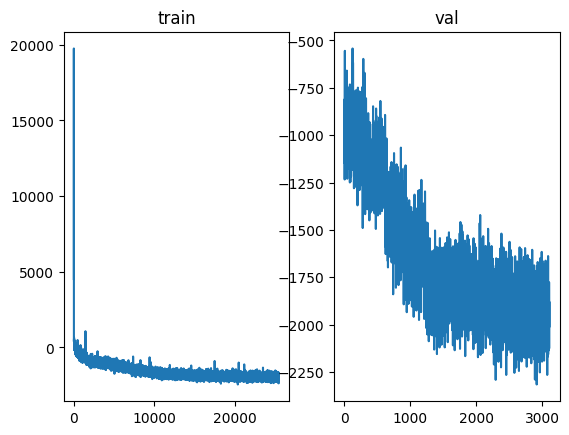

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(train_loss)
ax1.set_title('train')
ax2.plot(val_loss)
ax2.set_title('val')

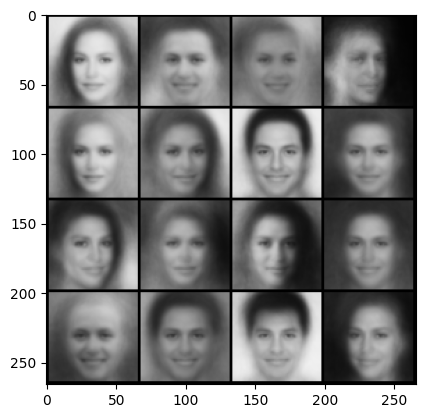

In [116]:
#!L
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device).view(images.shape[0], -1))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)
reconstruction = reconstruction.view(reconstruction.shape[0], 1, 64, 64)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

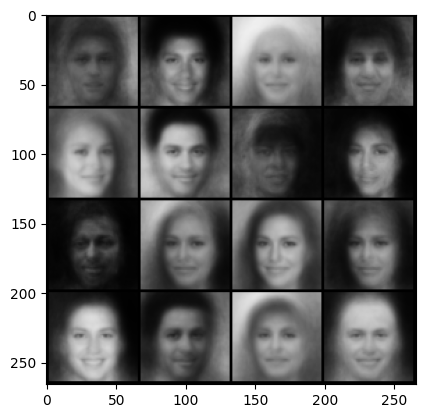

In [118]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)

#!L
z = torch.randn(16, dimZ) #* 0.5
reconstruction, _ = torch.split(vae.decoder(z.to(device)), 64 * 64, -1)
reconstruction = torch.sigmoid(reconstruction).view(reconstruction.shape[0], 1, 64, 64)
plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


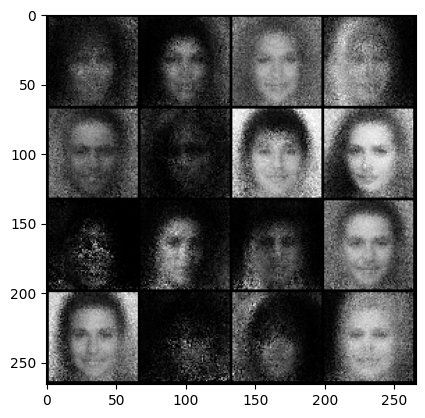

In [123]:
#!L
# TODO
# Sample some images from the learned distribution
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

#!L
z = torch.randn(16, dimZ)
reco_mu, reco_logsigma = torch.split(vae.decoder(z.to(device)).cpu(), 64 * 64, -1)

reco_mu = torch.sigmoid(reco_mu)
reco_logsigma = vae.softclip(reco_logsigma, -6)

reconstruction = torch.randn_like(reco_mu) * reco_logsigma.exp() * 0.5 + reco_mu
reconstruction = reconstruction.view(reconstruction.shape[0], 1, 64, 64)

plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [182]:
pos = []
pos_orig = []
neg = []
neg_orig = []

for i, (batch, attr) in tqdm(enumerate(train_loader)):
    with torch.no_grad():
        batch = batch.to(device).view(batch.shape[0], -1)
        mu_z, logsigma_z = torch.split(vae.encoder(batch), dimZ, -1)
    (pos_ids,) = torch.where(attr[:,31] == 1)
    pos.extend(mu_z[pos_ids])
    pos_orig.extend(batch[pos_ids])
    (neg_ids,) = torch.where(attr[:,31] == 0)
    neg.extend(mu_z[neg_ids])      
    neg_orig.extend(batch[neg_ids])
    
    if i == 100:
        break
    
pos = torch.stack(pos)
neg = torch.stack(neg)

pos_orig = torch.stack(pos_orig)
neg_orig = torch.stack(neg_orig)

100it [00:06, 16.66it/s]


In [183]:
delta = torch.mean(pos[:10], dim=0) - torch.mean(neg[:10], dim=0)
delta.shape, delta.sum()

(torch.Size([512]), tensor(-0.5444, device='cuda:1'))

tensor(-0.0925, device='cuda:1') tensor(-0.5444, device='cuda:1') hui


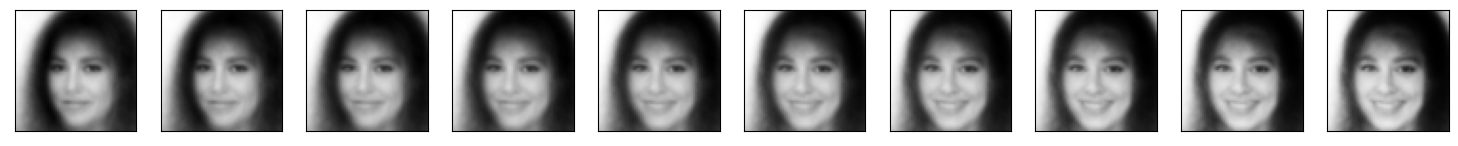

In [203]:
img_id = 35
z = neg[img_id].clone()
print(z.sum(), delta.sum(), 'hui')

fig, ax = plt.subplots(1, 10)
fig.set_size_inches(18.5, 3)
for i in range(10):

    with torch.no_grad():
        img, _ = torch.split(vae.decoder(z.unsqueeze(dim=0)), 64 * 64, -1)
    img = torch.sigmoid(img).cpu().view(64, 64)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    z += delta / 10 * 5